In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy.interpolate import CubicSpline
from scipy.stats import chi2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import seaborn as sns
import calendar

from gp_mjo.gp_mjo_model import rolling

In [2]:
npzfile = np.load('../data/mjo_new_data.npz', allow_pickle=True)
print(npzfile.files)
print(npzfile['RMM1'].shape)

data_names = npzfile.files + ['id']
n_files = len(data_names)

entire_npzfile = {}
for i, data_name in enumerate(data_names):
    if i < n_files-1:
        entire_npzfile[data_name] = npzfile[data_name]
    if i == n_files-1:
        entire_npzfile[data_name] = np.arange(len(npzfile['RMM1']))

['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
(16026,)


In [3]:
class emp_gp_mjo:
    def __init__(self, npzfile, width=40, lead_time=60, n = 10000, start_train=0, season_bool=False) -> None:
        self.npzfile = npzfile
        self.width = width
        self.lead_time = lead_time
        self.n = n
        self.start_train = start_train
        d = width + lead_time
        self.n_train = d + n    

        errlist = ['cor','rmse','phase','amplitude','hss','hss_n']
        self.errs = {key: None for key in errlist}

        train_data = np.array([])
        #train_y = np.array([])
        train_ids = np.arange(start_train, start_train + self.n_train)
        train_rmms = np.array([])
        for rmm in ['RMM1','RMM2']:
            if season_bool:
                train_datarmm = np.array([]).reshape(-1, d)
                #train_yrmm = np.array([]).reshape(-1, 1)
                train_id_split = np.hstack( ( np.array([0]), 
                            np.where(np.ediff1d(npzfile['id'][train_ids]) != 1 )[0]+1, 
                            np.array([len(npzfile['id'][train_ids])]) ) )
                diff_train_ids = np.ediff1d(train_id_split)
                
                for i, diff_train_id in enumerate(diff_train_ids):
                    if diff_train_id <= d:
                        print(f'width+lead_time = {d} is greater than the current interval width {diff_train_id}, will skip {i}-th iteration for {rmm}')
                        continue
                    split_start = train_id_split[i]
                    split_end = train_id_split[i+1]
                    train_ij = npzfile[rmm][train_ids][split_start:split_end]
                    train_rmms = np.hstack((train_rmms, train_ij))

                    train_datarmm = np.vstack(( train_datarmm, rolling(train_ij[:-1], d) )) # (n, d) numpy array
                    #train_yrmm = np.vstack(( train_yrmm, train_ij[d:].reshape(-1,1) )) # (n, 1) numpy array
            
            else:    
                train_ij = npzfile[rmm][train_ids]
                train_rmms = np.hstack((train_rmms, train_ij))

                train_datarmm = rolling(train_ij[:-1], d) # (n, d) numpy array
                #train_yrmm = train_ij[d:].reshape(-1,1) # (n, 1) numpy array
            
            train_data = train_data.reshape(train_datarmm.shape[0], -1)
            #train_y = train_y.reshape(train_yrmm.shape[0], -1)

            train_data = np.hstack(( train_data, train_datarmm )) # (n, 2*d) numpy array
            #train_y = np.hstack( (train_y, train_yrmm) ) # (n, 2) numpy array

        self.train_data = train_data # (n, 2*d) numpy array
        #self.train_y = train_y
        self.train_rmms = train_rmms
        self.d = d


    def get_emp(self):
        width = self.width
        lead_time = self.lead_time
        d = self.d
        train_data = self.train_data # (n, 2*d) numpy array

        self.train_mean = np.mean(train_data, axis=0) # (2*d, ) numpy array
        self.train_cov = (train_data - self.train_mean).T @ (train_data - self.train_mean) / (train_data.shape[0]-1) # (2*d, 2*d) numpy array   
    
        #===================================================
        # use cubic spline to get cov([RMM1,RMM2],[RMM1,RMM2])
        #===================================================
        pts_spl = np.linspace(0.0, d, num=d, endpoint=True) # (d, ) array
        dist_spl = np.sqrt(( pts_spl.reshape(-1,1) - pts_spl )**2) # (d, d) array, distance matrix
        x_spl = dist_spl[0,:] # (d, ) array, 1st row of dist_spl
        
        # RMM1
        y_spl_rmm1 = self.train_cov[0,:d]
        spl_rmm1 = CubicSpline(x_spl, y_spl_rmm1)
        rmm1_cov = spl_rmm1(dist_spl) # (d, d) array

        # RMM2
        y_spl_rmm2 = self.train_cov[d,d:2*d]
        spl_rmm2 = CubicSpline(x_spl, y_spl_rmm2)
        rmm2_cov = spl_rmm2(dist_spl) # (d, d) array

        # RMM1-RMM2
        yupper_spl = self.train_cov[0,d:2*d]
        spl_rmm12upper = CubicSpline(x_spl, yupper_spl)
        rmm12upper_cov = spl_rmm12upper(dist_spl) # (d, d) array
        
        ylower_spl = np.flip( self.train_cov[d-1,d:2*d])
        spl_rmm12lower = CubicSpline(x_spl, ylower_spl)
        rmm12lower_cov = spl_rmm12lower(dist_spl) # (d, d) array

        #rmm12_cov = np.triu(rmm12upper_cov, k=1) + np.tril(-rmm12upper_cov, k=-1) + np.diag(np.diag( (rmm12upper_cov - rmm12upper_cov)/2 ))
        rmm12_cov = np.triu(rmm12upper_cov, k=1) + np.tril(rmm12lower_cov, k=-1) + np.diag(np.diag( (rmm12upper_cov + rmm12lower_cov)/2 ))

        pred_cov = np.vstack(( np.hstack((rmm1_cov,rmm12_cov)), np.hstack((rmm12_cov.T,rmm2_cov)) )) # (2*d, 2*d) array
        pred_mean = self.train_mean # (2*d, ) numpy array

        mu1 = {}
        mu2 = {}
        K11 = {}
        K12 = {}
        K21 = {}
        K22 = {}
        K11_inv = {}
        K21_11 = {}
        Kcond = {}
        for j in range(lead_time):
            mu1[j] = np.hstack(( pred_mean[j:j+width],  pred_mean[j+d:j+d+width] )) # (2*width, ) numpy array
            mu2[j] = np.hstack(( pred_mean[j+width],  pred_mean[j+d+width] )) # (2, ) numpy array

            K11[j] = np.vstack((
                            np.hstack(( pred_cov[j:j+width,j:j+width], pred_cov[j:j+width,j+d:j+d+width] )),
                            np.hstack(( pred_cov[j+d:j+d+width,j:j+width], pred_cov[j+d:j+d+width,j+d:j+d+width] ))
                            )) # (2*width, 2*width) numpy array
            K12[j] = np.vstack((
                            np.hstack(( pred_cov[j:j+width,j+width][:,None], pred_cov[j:j+width,j+d+width][:,None] )),
                            np.hstack(( pred_cov[j+d:j+d+width,j+width][:,None], pred_cov[j+d:j+d+width,j+d+width][:,None] ))
                            )) # (2*width, 2) numpy array
            K21[j]  = np.vstack((
                            np.hstack(( pred_cov[j+width,j:j+width][None,:], pred_cov[j+width,j+d:j+d+width][None,:] )),
                            np.hstack(( pred_cov[j+d+width,j:j+width][None,:], pred_cov[j+d+width,j+d:j+d+width][None,:] ))
                            )) # (2, 2*width) numpy array
            K22[j]  = np.vstack((
                            np.hstack(( pred_cov[j+width,j+width], pred_cov[j+width,j+d+width] )),
                            np.hstack(( pred_cov[j+d+width,j+width], pred_cov[j+d+width,j+d+width] ))
                            )) # (2, 2) numpy array
        
            K11_inv[j] = np.linalg.inv(K11[j]) # (2*width, 2*width) numpy array
            K21_11[j] = K21[j] @ K11_inv[j] # (2, 2*width) numpy array
            Kcond[j] = K22[j] - K21_11[j] @ K12[j] # (2, 2) array


        self.pred_mean = pred_mean
        self.pred_cov = pred_cov

        self.mu1 = mu1
        self.mu2 = mu2
        self.K11 = K11
        self.K12 = K12
        self.K21 = K21
        self.K22 = K22
        self.K11_inv = K11_inv
        self.K21_11 = K21_11
        self.Kcond = Kcond


    def get_biasvar(self, start_val, n_pred = 1, v = 2500, season_bool=False):
        npzfile = self.npzfile
        width = self.width
        lead_time = self.lead_time
        d = self.d
        val_ids = np.arange(start_val, start_val + v)

        val_id_split = np.hstack( ( np.array([0]), 
                            np.where(np.ediff1d(npzfile['id'][val_ids]) != 1 )[0]+1, 
                            np.array([len(npzfile['id'][val_ids])]) ) )
        diff_val_ids = np.ediff1d(val_id_split)
        max_diff = np.max(diff_val_ids)
        freq_diff = np.bincount(diff_val_ids).argmax() # return the most frequent value in diff_val_ids
    
        if season_bool or len(val_id_split) > 2:
            if width >= freq_diff:
                raise ValueError(f'the width is greater than the season interval, please try a width value < {freq_diff}')
            if lead_time + width > freq_diff:
                print(f"the sum of the width and lead time is greater than the season interval..., will set lead time = {freq_diff-width}")
                lead_time = freq_diff-width
            
            pred_ids_start = val_id_split[:-1]
            pred_ids_end = (val_id_split - lead_time - width + 1)[1:]
            pred_ids = np.array([],dtype=int)
            for ii in range(len(pred_ids_start)):
                if (pred_ids_start[ii] >= pred_ids_end[ii]):
                    continue
                pred_ids_i = np.arange( start=pred_ids_start[ii], stop=pred_ids_end[ii] )
                pred_ids = np.hstack( (pred_ids,pred_ids_i), dtype=int)
            
            if n_pred > len(pred_ids):
                print(f"the number of predictions is greater than the number of the season intervals..., will set n_pred = {len(pred_ids)}")
                n_pred = len(pred_ids)            
            
        else:
            pred_ids = np.arange(n_pred)
        
        obs = {}
        observed_preds = {}
        lower_confs = {}
        upper_confs = {}
        predvar = {}
        biasvar = {}

        obs['phase'] = np.zeros((n_pred,lead_time))
        obs['amplitude'] = np.zeros((n_pred,lead_time))
        rmms = ['RMM1','RMM2']
        for rmm in rmms:
            obs[rmm] = np.zeros((n_pred,lead_time))
            observed_preds[rmm] = np.zeros((n_pred,lead_time))
            lower_confs[rmm] = np.zeros((n_pred,lead_time))
            upper_confs[rmm] = np.zeros((n_pred,lead_time))
            predvar[rmm] = np.zeros((n_pred,lead_time))
            biasvar[rmm] = np.zeros((n_pred,lead_time))
        
        y_mean = {}
        y_cov = {}
        for i, pred_i in enumerate(pred_ids[:n_pred]):
            for j in range(lead_time):
                obs['phase'][i,j] = npzfile['phase'][val_ids][pred_i+j+width]
                obs['amplitude'][i,j] = npzfile['amplitude'][val_ids][pred_i+j+width]
                input_x = np.hstack(( npzfile['RMM1'][val_ids][pred_i+j : pred_i+j+width], \
                                      npzfile['RMM2'][val_ids][pred_i+j : pred_i+j+width] )) # (2*width, ) array

                if j == 0:
                    mean_val_x = input_x # (2*width, ) array
                else:
                    mean_val_x_1 = np.hstack(( mean_val_x[1:width], y_mean[i,j-1][0] )) # (width, ) array
                    mean_val_x_2 = np.hstack(( mean_val_x[width+1:2*width], y_mean[i,j-1][1] )) # (width, ) array
                    mean_val_x = np.hstack(( mean_val_x_1, mean_val_x_2 )) # (2*width, ) array
                    
                y_mean[i,j] = self.mu2[j][:,None] + self.K21_11[j] @ (mean_val_x[:,None] - self.mu1[j][:,None]) # (2, 1) numpy array
                #y_cov[i,j] = self.Kcond[j] #+ sample_cov (2,2) numpy array

                
                for k, rmm in enumerate(rmms):
                    predvar[rmm][i,j] = self.Kcond[j][k,k]#y_cov[i,j][k,k]
                    obs[rmm][i,j] = npzfile[rmm][val_ids][pred_i+j+width]
                    biasvar[rmm][i,j] = (y_mean[i,j][k,0] - obs[rmm][i,j])**2

        std = {}
        var = {}
        for rmm in rmms:
            biasvar_mean = np.sum(biasvar[rmm],axis=0) / (n_pred) # (lead_time, ) array
            var[rmm] = predvar[rmm] + biasvar_mean # (n_pred, lead_time) array
            std[rmm] = np.sqrt(var[rmm]) # (n_pred, lead_time) array

        Kcond_correct = {}
        for j in range(lead_time):
            rmm1_correct = var['RMM1'][0,j]
            rmm2_correct = var['RMM2'][0,j]
            rmm12_correct = np.sqrt( rmm1_correct*rmm2_correct ) * self.Kcond[j][0,1] / np.sqrt( self.Kcond[j][0,0] * self.Kcond[j][1,1] )
            rmm21_correct = np.sqrt( rmm1_correct*rmm2_correct ) * self.Kcond[j][1,0] / np.sqrt( self.Kcond[j][0,0] * self.Kcond[j][1,1] )
            Kcond_correct[j] = np.array( [ [rmm1_correct, rmm12_correct], [rmm21_correct, rmm2_correct] ] ) # (2, 2) array

        self.lead_time = lead_time
        self.v = v
        self.start_val = start_val
        self.std = std
        self.Kcond_correct = Kcond_correct
        

    def pred(self, start_test, n_pred = 1, m = 1500, season_bool=False):
        npzfile = self.npzfile
        width = self.width
        lead_time = self.lead_time
        d = self.d
        Ns = 1000#self.train_data.shape[0] # the number of samplings is set to the number of training
        test_ids = np.arange(start_test, start_test + m)

        test_id_split = np.hstack( ( np.array([0]), 
                            np.where(np.ediff1d(npzfile['id'][test_ids]) != 1 )[0]+1, 
                            np.array([len(npzfile['id'][test_ids])]) ) )
        diff_test_ids = np.ediff1d(test_id_split)
        max_diff = np.max(diff_test_ids)
        freq_diff = np.bincount(diff_test_ids).argmax() # return the most frequent value in diff_test_ids
    
        if season_bool or len(test_id_split) > 2:
            if width >= freq_diff:
                raise ValueError(f'the width is greater than the season interval, please try a width value < {freq_diff}')
            if lead_time + width > freq_diff:
                print(f"the sum of the width and lead time is greater than the season interval..., will set lead time = {freq_diff-width}")
                lead_time = freq_diff-width
            
            pred_ids_start = test_id_split[:-1]
            pred_ids_end = (test_id_split - lead_time - width + 1)[1:]
            pred_ids = np.array([],dtype=int)
            for ii in range(len(pred_ids_start)):
                if (pred_ids_start[ii] >= pred_ids_end[ii]):
                    continue
                pred_ids_i = np.arange( start=pred_ids_start[ii], stop=pred_ids_end[ii] )
                pred_ids = np.hstack( (pred_ids,pred_ids_i), dtype=int)
            
            if n_pred > len(pred_ids):
                print(f"the number of predictions is greater than the number of the season intervals..., will set n_pred = {len(pred_ids)}")
                n_pred = len(pred_ids)            
            
        else:
            pred_ids = np.arange(n_pred)
        
        obs = {}
        observed_preds = {}
        lower_confs = {}
        upper_confs = {}

        obs['year'] = np.zeros((n_pred,lead_time))
        obs['month'] = np.zeros((n_pred,lead_time))
        obs['day'] = np.zeros((n_pred,lead_time))
        obs['phase'] = np.zeros((n_pred,lead_time))
        obs['amplitude'] = np.zeros((n_pred,lead_time))

        rmms = ['RMM1','RMM2']
        for rmm in rmms:
            obs[rmm] = np.zeros((n_pred,lead_time))
            observed_preds[rmm] = np.zeros((n_pred,lead_time))
            lower_confs[rmm] = np.zeros((n_pred,lead_time))
            upper_confs[rmm] = np.zeros((n_pred,lead_time))
        
        y_mean = {}#[[0]*lead_time]*n_pred
        y_cov = {}#[[0]*lead_time]*n_pred
        for i, pred_i in enumerate(pred_ids[:n_pred]):
            for j in range(lead_time):
                obs['year'][i,j] = npzfile['year'][test_ids][pred_i+j+width]
                obs['month'][i,j] = npzfile['month'][test_ids][pred_i+j+width]
                obs['day'][i,j] = npzfile['day'][test_ids][pred_i+j+width]
                obs['phase'][i,j] = npzfile['phase'][test_ids][pred_i+j+width]
                obs['amplitude'][i,j] = npzfile['amplitude'][test_ids][pred_i+j+width]
                input_x = np.hstack(( npzfile['RMM1'][test_ids][pred_i+j : pred_i+j+width], \
                                      npzfile['RMM2'][test_ids][pred_i+j : pred_i+j+width] )) # (2*width, ) array

                if j == 0:
                    mean_test_x = input_x # (2*width, ) array
                    #cov_test_x = np.zeros((2*width,2*width)) # (2*width, 2*width) array
                else:
                    mean_test_x_1 = np.hstack(( mean_test_x[1:width], y_mean[i,j-1][0] )) # (width, ) array
                    mean_test_x_2 = np.hstack(( mean_test_x[width+1:2*width], y_mean[i,j-1][1] )) # (width, ) array
                    mean_test_x = np.hstack(( mean_test_x_1, mean_test_x_2 )) # (2*width, ) array
                    
                    # K = {}
                    # for ii in range(2):
                    #     for jj in range(2):
                    #         test_x_samples_ii = test_x_samples[:,ii*width:(ii+1)*width] # (Ns, width) array
                    #         test_x_samples_jj = test_x_samples[:,jj*width:(jj+1)*width] # (Ns, width) array
                    #         y_samples_ii = y_samples[:,ii][:,None] # (Ns, 1) array
                    #         y_samples_jj = y_samples[:,jj][:,None] # (Ns, 1) array

                    #         K11_ij = cov_test_x[ (ii*width+1):(ii+1)*width, (jj*width+1):(jj+1)*width ] # (width-1, width-1) array
                    #         K12_ij = (1/(Ns-1)) * ( test_x_samples_ii[:,1:width] - np.mean(test_x_samples_ii[:,1:width], axis=0) ).T \
                    #         @ ( y_samples_jj - np.mean(y_samples_jj, axis=0) ) # (width-1, Ns) @ (Ns, 1) = (width-1, 1) array
                    #         K21_ij = (1/(Ns-1)) * ( y_samples_ii - np.mean(y_samples_ii, axis=0) ).T \
                    #         @ ( test_x_samples_jj[:,1:width] - np.mean(test_x_samples_jj[:,1:width], axis=0) ) # (1, Ns) @ (Ns, width-1) = (1, width-1) array
                    #         K22_ij = (1/(Ns-1)) * ( y_samples_ii - np.mean(y_samples_ii, axis=0) ).T @ ( y_samples_jj - np.mean(y_samples_jj, axis=0) ) # (1, Ns) @ (Ns, 1) = (1, 1) array
                    #         #K22_ij = y_cov[i,j-1][ii,jj].reshape(1,1) (1, 1) array
                    #         K[ii,jj] = np.vstack(( np.hstack((K11_ij,K12_ij)), np.hstack((K21_ij,K22_ij)) )) # (width, width) array
                    
                    # cov_test_x = np.vstack(( np.hstack((K[0,0],K[0,1])), np.hstack((K[1,0],K[1,1])) )) # (2*width, 2*width) array
                
                # # generate test_x samplings, test_x ~ N(mean_test_x, cov_test_x), test_x = [z_{k-width},...,z_{k-1}]
                # test_x_samples = np.random.multivariate_normal(mean=mean_test_x, cov=cov_test_x, size=Ns) # (Ns, 2*width) array

                # pred_cov[j:j+width,j:j+width] += cov_test_x[:width,:width]
                # pred_cov[j:j+width,j+d:j+d+width] += cov_test_x[:width,width:2*width]
                # pred_cov[j+d:j+d+width,j:j+width] += cov_test_x[width:2*width,:width]
                # pred_cov[j+d:j+d+width,j+d:j+d+width] += cov_test_x[width:2*width,width:2*width]

                # make predictions by empirical mean and covaraince

                
                # mean_samples = mu2[:,None] + K21 @ K11_inv @ (test_x_samples.T - mu1[:,None]) # (2, Ns) numpy array
                # diff_mean_samples = (mean_samples - np.mean(mean_samples,axis=1)[:,None]) # (2, Ns) numpy array
                # sample_cov = diff_mean_samples @ diff_mean_samples.T / (Ns-1) # (2,2) numpy array
                # y_mean[i,j] = np.mean(mean_samples,axis=1)[:,None] # (2, 1) numpy array
                y_mean[i,j] = self.mu2[j][:,None] + self.K21_11[j] @ (mean_test_x[:,None] - self.mu1[j][:,None]) # (2, 1) numpy array
                # y_cov[i,j] = K22 - K21 @ K11_inv @ K12 + sample_cov # (2,2) numpy array

                # generate test_x samplings, test_x ~ N(mean_test_x, cov_test_x), test_x = [z_{k-width},...,z_{k-1}]
                #test_x_samples = np.random.multivariate_normal(mean=mean_test_x, cov=cov_test_x, size=Ns) # (Ns, 2*width) array

                # # generate y samplings, y = [z_{k}], y ~ N(y_mean, y_var)
                # y_samples = np.random.multivariate_normal(mean=y_mean[i,j][:,0], cov=y_cov[i,j], size=Ns) # (Ns, 2) array
                
                
                for k, rmm in enumerate(rmms):
                    obs[rmm][i,j] = npzfile[rmm][test_ids][pred_i+j+width]
                    observed_preds[rmm][i,j] = y_mean[i,j][k,0]
                    lower_confs[rmm][i,j] = y_mean[i,j][k,0] - 1.00 * self.std[rmm][i,j] # np.sqrt(y_cov[i,j][k,k])
                    upper_confs[rmm][i,j] = y_mean[i,j][k,0] + 1.00 * self.std[rmm][i,j] # np.sqrt(y_cov[i,j][k,k])

        self.lead_time = lead_time
        self.n_pred = n_pred
        self.m = m
        self.start_test = start_test
        self.pred_ids = pred_ids
        
        self.obs = obs
        self.observed_preds = observed_preds
        self.lower_confs = lower_confs
        self.upper_confs = upper_confs


    def rmm_to_phase(self, pred_rmm1=None, pred_rmm2=None):
        if pred_rmm1 is None:
            pred_rmm1 = self.observed_preds['RMM1']
        if pred_rmm2 is None:
            pred_rmm2 = self.observed_preds['RMM2']
        rmm_angle = np.arctan2(pred_rmm2,pred_rmm1) * 180 / np.pi
        phase = np.zeros(pred_rmm1.shape)

        for i in range(8):
            lower_angle = - 180. * (1 - i / 4.)
            upper_angle = - 180. * (1 - (i+1) / 4.)
            bool_angle = (rmm_angle > lower_angle) & (rmm_angle <= upper_angle)
            phase += bool_angle.astype('int64')*(i+1)
       
        self.observed_preds['phase'] = phase.astype(int)
        return self.observed_preds['phase']

    def rmm_to_amplitude(self, pred_rmm1=None, pred_rmm2=None):
        """ampltitude is the norm of (RMM1, RMM2)
        """
        if pred_rmm1 is None:
            pred_rmm1 = self.observed_preds['RMM1']
        if pred_rmm2 is None:
            pred_rmm2 = self.observed_preds['RMM2']
        amplitude = np.sqrt( np.square(pred_rmm1) + np.square(pred_rmm2) )
        self.observed_preds['amplitude'] = amplitude
        return amplitude

    
    def cor(self):
        """bivariate correlation coefficien
        """
        pred_rmm1 = self.observed_preds['RMM1']
        pred_rmm2 = self.observed_preds['RMM2']

        obs_rmm1 = self.obs['RMM1']
        obs_rmm2 = self.obs['RMM2']

        numerator = np.sum((obs_rmm1*pred_rmm1 + obs_rmm2*pred_rmm2), axis=0) # 1*lead_time numpy array
        denominator = np.sqrt(np.sum((obs_rmm1**2 + obs_rmm2**2),axis=0)) \
            * np.sqrt(np.sum((pred_rmm1**2 + pred_rmm2**2),axis=0))
        self.errs['cor'] = (numerator / denominator).reshape(-1) # shape = (lead_time,) numpy array

        return self.errs['cor']
    
   
    def rmse(self):
        pred_rmm1 = self.observed_preds['RMM1']
        pred_rmm2 = self.observed_preds['RMM2']

        obs_rmm1 = self.obs['RMM1']
        obs_rmm2 = self.obs['RMM2']
        n_pred = pred_rmm1.shape[0]

        sum_rmm1 = np.sum((obs_rmm1-pred_rmm1)**2, axis=0)
        sum_rmm2 = np.sum((obs_rmm2-pred_rmm2)**2, axis=0)
        self.errs['rmse'] = ( np.sqrt( (sum_rmm1 + sum_rmm2) / n_pred ) ).reshape(-1)

        return self.errs['rmse']


    def phase_err(self):
        pred_rmm1 = self.observed_preds['RMM1']
        pred_rmm2 = self.observed_preds['RMM2']

        obs_rmm1 = self.obs['RMM1']
        obs_rmm2 = self.obs['RMM2']
        n_pred = pred_rmm1.shape[0]

        num = obs_rmm1*pred_rmm2 - obs_rmm2*pred_rmm1
        den = obs_rmm1*pred_rmm1 + obs_rmm2*pred_rmm2

        temp = np.arctan(np.divide(num,den))
        self.errs['phase'] = ( np.sum(temp, axis=0) / n_pred ).reshape(-1)

        return self.errs['phase']

   
    def amplitude_err(self):
        pred_rmm1 = self.observed_preds['RMM1']
        pred_rmm2 = self.observed_preds['RMM2']
        n_pred = pred_rmm1.shape[0]
        preds_amplitude = self.rmm_to_amplitude(pred_rmm1,pred_rmm2)
        
        obs_amplitude = self.obs['amplitude']

        self.errs['amplitude'] = (np.sum((preds_amplitude - obs_amplitude),axis=0) / n_pred).reshape(-1)

        return self.errs['amplitude']

    def hss(self):
        pred_rmm1 = self.observed_preds['RMM1']
        pred_rmm2 = self.observed_preds['RMM2']
        preds_phase = self.rmm_to_phase(pred_rmm1,pred_rmm2) # (n_pred,lead_time)
        preds_amplitude = self.rmm_to_amplitude(pred_rmm1,pred_rmm2) # (n_pred,lead_time)

        obs_phase = self.obs['phase'] # (n_pred,lead_time)
        obs_amplitude = self.obs['amplitude'] # (n_pred,lead_time)

        lead_time = pred_rmm1.shape[1]
        hss_phase = np.zeros((9,lead_time))
        hss_n = np.zeros((9,lead_time))
        for phase_num in np.arange(9):
            if phase_num == 0: # whether the mjo is strong / whether it is a mjo event
                a = np.count_nonzero( (preds_amplitude < 1) & (obs_amplitude <1), axis=0) # (lead_time, ) array
                b = np.count_nonzero( (preds_amplitude < 1) & (obs_amplitude >= 1), axis=0) # (lead_time, ) array
                c = np.count_nonzero( (preds_amplitude >= 1) & (obs_amplitude < 1), axis=0) # (lead_time, ) array
                d = np.count_nonzero( (preds_amplitude >= 1) & (obs_amplitude >= 1), axis=0) # (lead_time, ) array
            else:
                a = np.count_nonzero( ( (preds_phase == phase_num) & (preds_amplitude >= 1) ) & ( (obs_phase == phase_num) & (obs_amplitude >= 1) ), axis=0)
                b = np.count_nonzero( ( (preds_phase == phase_num) & (preds_amplitude >= 1) ) & ( (obs_phase != phase_num) | (obs_amplitude < 1) ), axis=0)
                c = np.count_nonzero( ( (preds_phase != phase_num) | (preds_amplitude < 1) ) & ( (obs_phase == phase_num) & (obs_amplitude >= 1) ), axis=0)
                d = np.count_nonzero( ( (preds_phase != phase_num) | (preds_amplitude < 1) ) & ( (obs_phase != phase_num) | (obs_amplitude < 1) ), axis=0)
            
            n = a + b + c + d # (lead_time, ) array
            pc = (a[n != 0] + d[n != 0]) / n[n != 0] # (lead_time, ) array
            expect = ( (a[n != 0]+c[n != 0])*(a[n != 0]+b[n != 0]) + (b[n != 0]+d[n != 0])*(c[n != 0]+d[n != 0]) ) / (n[n != 0]**2)  # (lead_time, ) array or expect=0.5
            expect[expect==1] = 1 - 1e-6
            hss_phase[phase_num,n!=0] = (pc - expect) / (1 - expect) # (lead_time, ) array
            hss_phase[phase_num,n==0] = np.inf
            hss_n[phase_num,:] = n

        self.errs['hss'] = hss_phase
        self.errs['hss_n'] = hss_n
        return self.errs['hss']



## Entire

In [4]:
widths = [40,60]
n = 10000
v = 2000
m = 3500
lead_time = 60
start_train = 0
n_offset = 0
n_pred = 365*3

cor_entire = {}
rmse_entire = {}
phase_err_entire = {}
amplitude_err_entire = {}
hss_entire = {}
hss_n_entire = {}
K11_entire = {}
K22_entire = {}
dist_joint = {}
train_jointcov = {}
obs = {}
observed_preds = {}
lower_confs = {}
upper_confs = {}

n_trains = {}
n_vals = {}
start_vals = {}
start_tests = {}

for width in widths:
    n_trains[width] = width + n
    start_vals[width] = start_train + n_trains[width] + n_offset #- v - width - 1
    n_vals[width] = width + v
    #start_tests[width] = start_vals[width] + n_vals[width] + n_offset
    start_tests[width] = start_train + max(widths) + n + n_offset + max(widths) + v + n_offset + 10 + max(widths) - width

    emp_model = emp_gp_mjo(npzfile=entire_npzfile, width=width, lead_time=lead_time, n=n, start_train=start_train)
    emp_model.get_emp()
    emp_model.get_biasvar(start_val=start_vals[width], n_pred=365*4, v=v, season_bool=False)
    emp_model.pred(start_test=start_tests[width], n_pred=n_pred, m=m, season_bool=False)

    # compute errors
    cor_entire[width] = emp_model.cor()
    rmse_entire[width] = emp_model.rmse()
    phase_err_entire[width] = emp_model.phase_err()
    amplitude_err_entire[width] = emp_model.amplitude_err()
    hss_entire[width] = emp_model.hss()
    hss_n_entire[width] = emp_model.errs['hss_n']


    obs[width] = emp_model.obs
    observed_preds[width] = emp_model.observed_preds
    lower_confs[width] = emp_model.lower_confs
    upper_confs[width] = emp_model.upper_confs

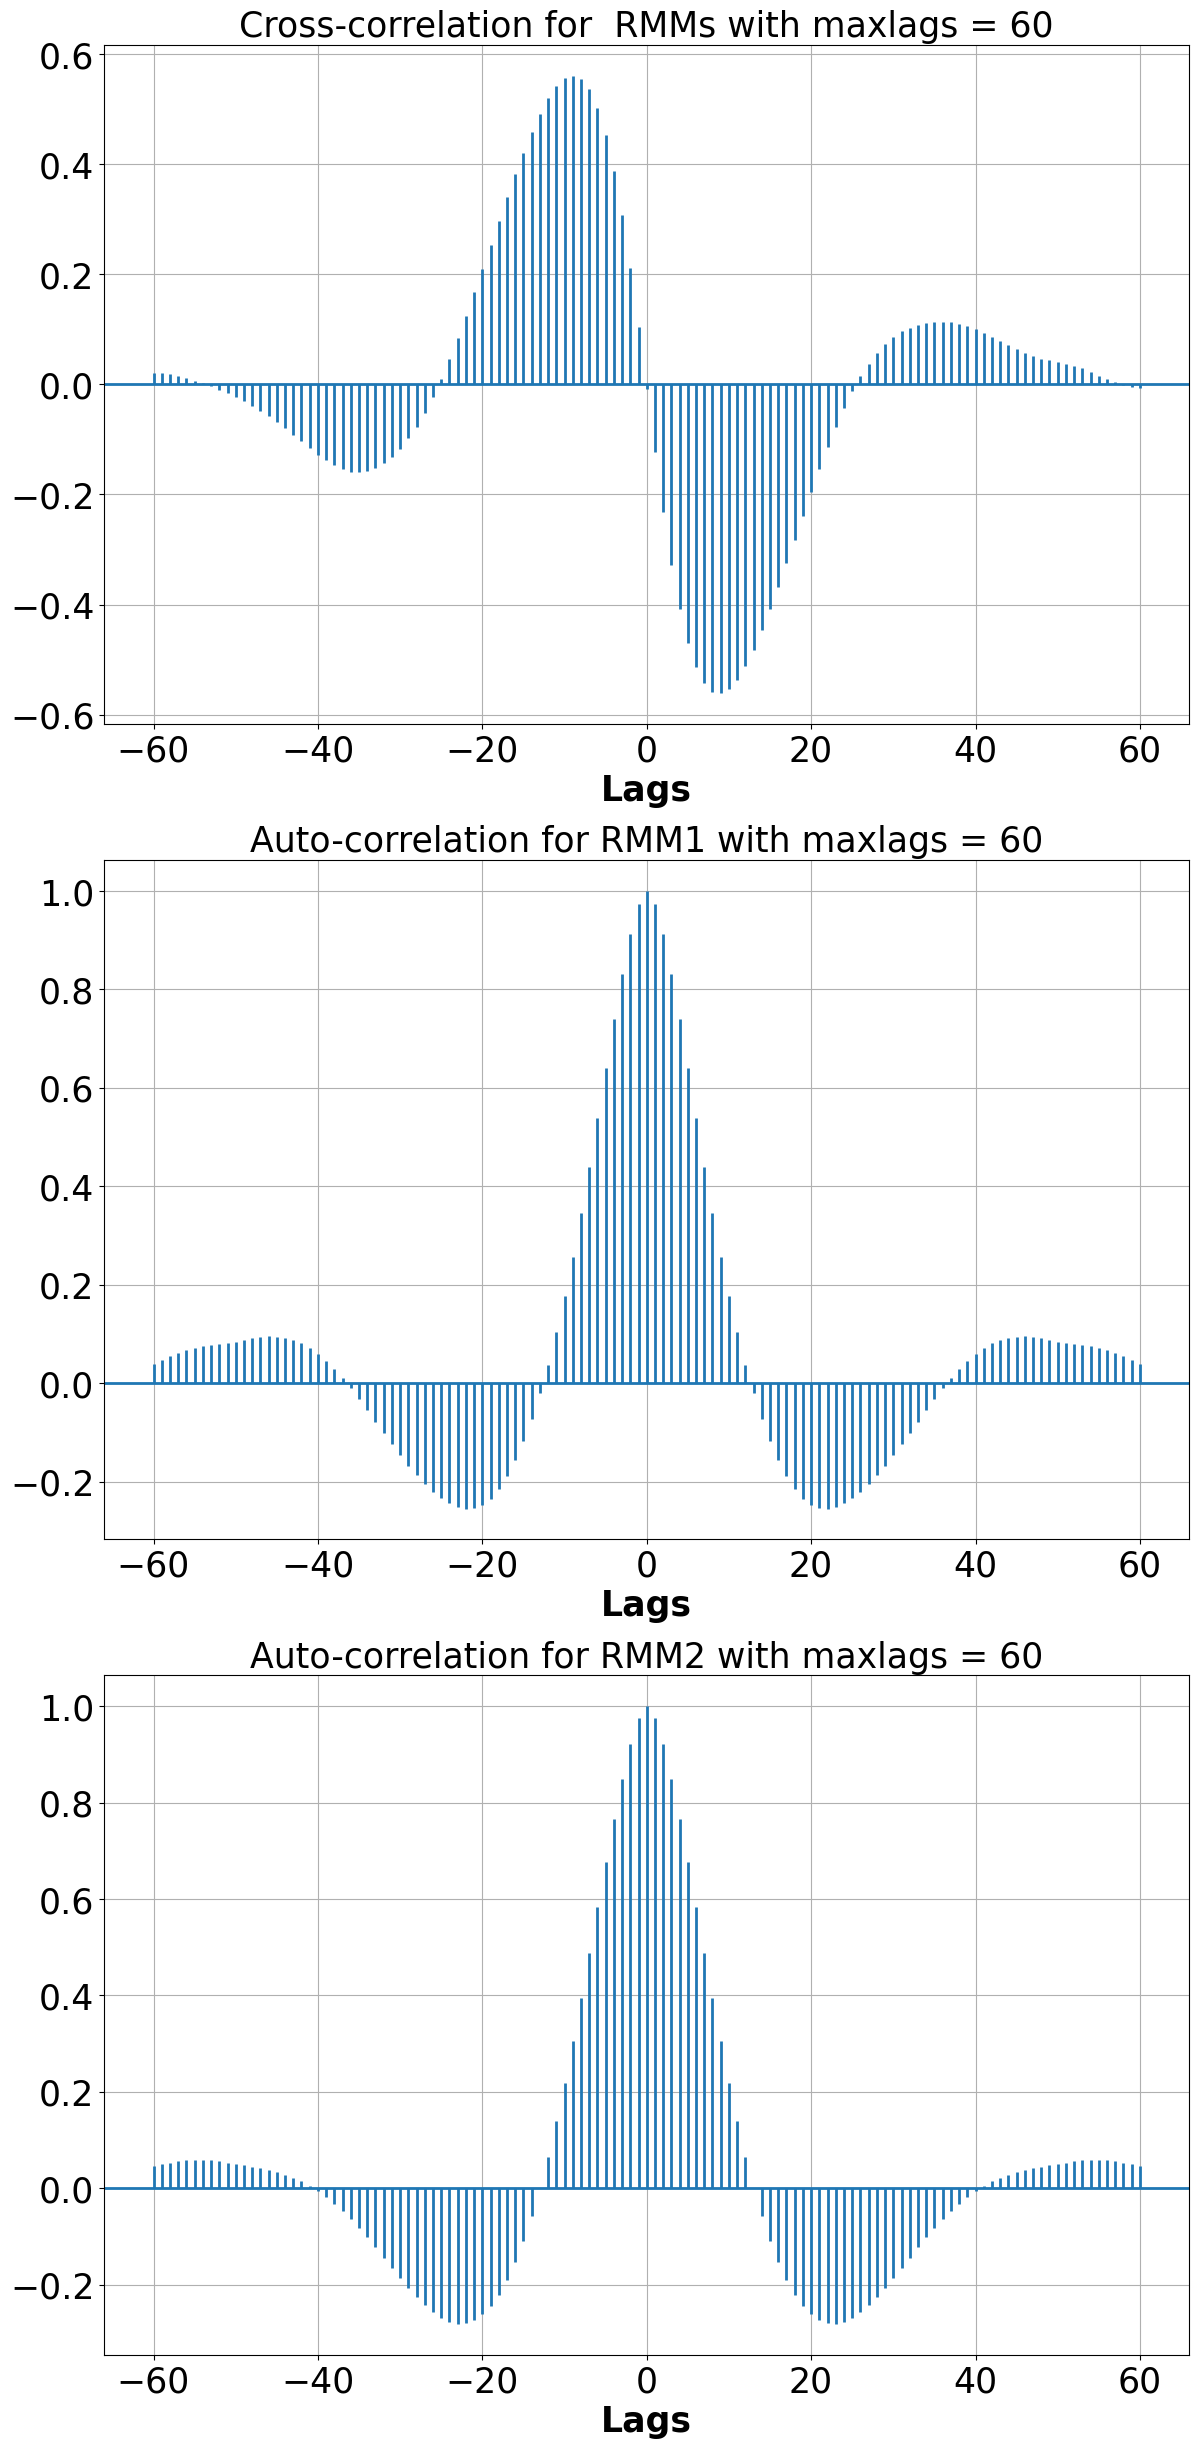

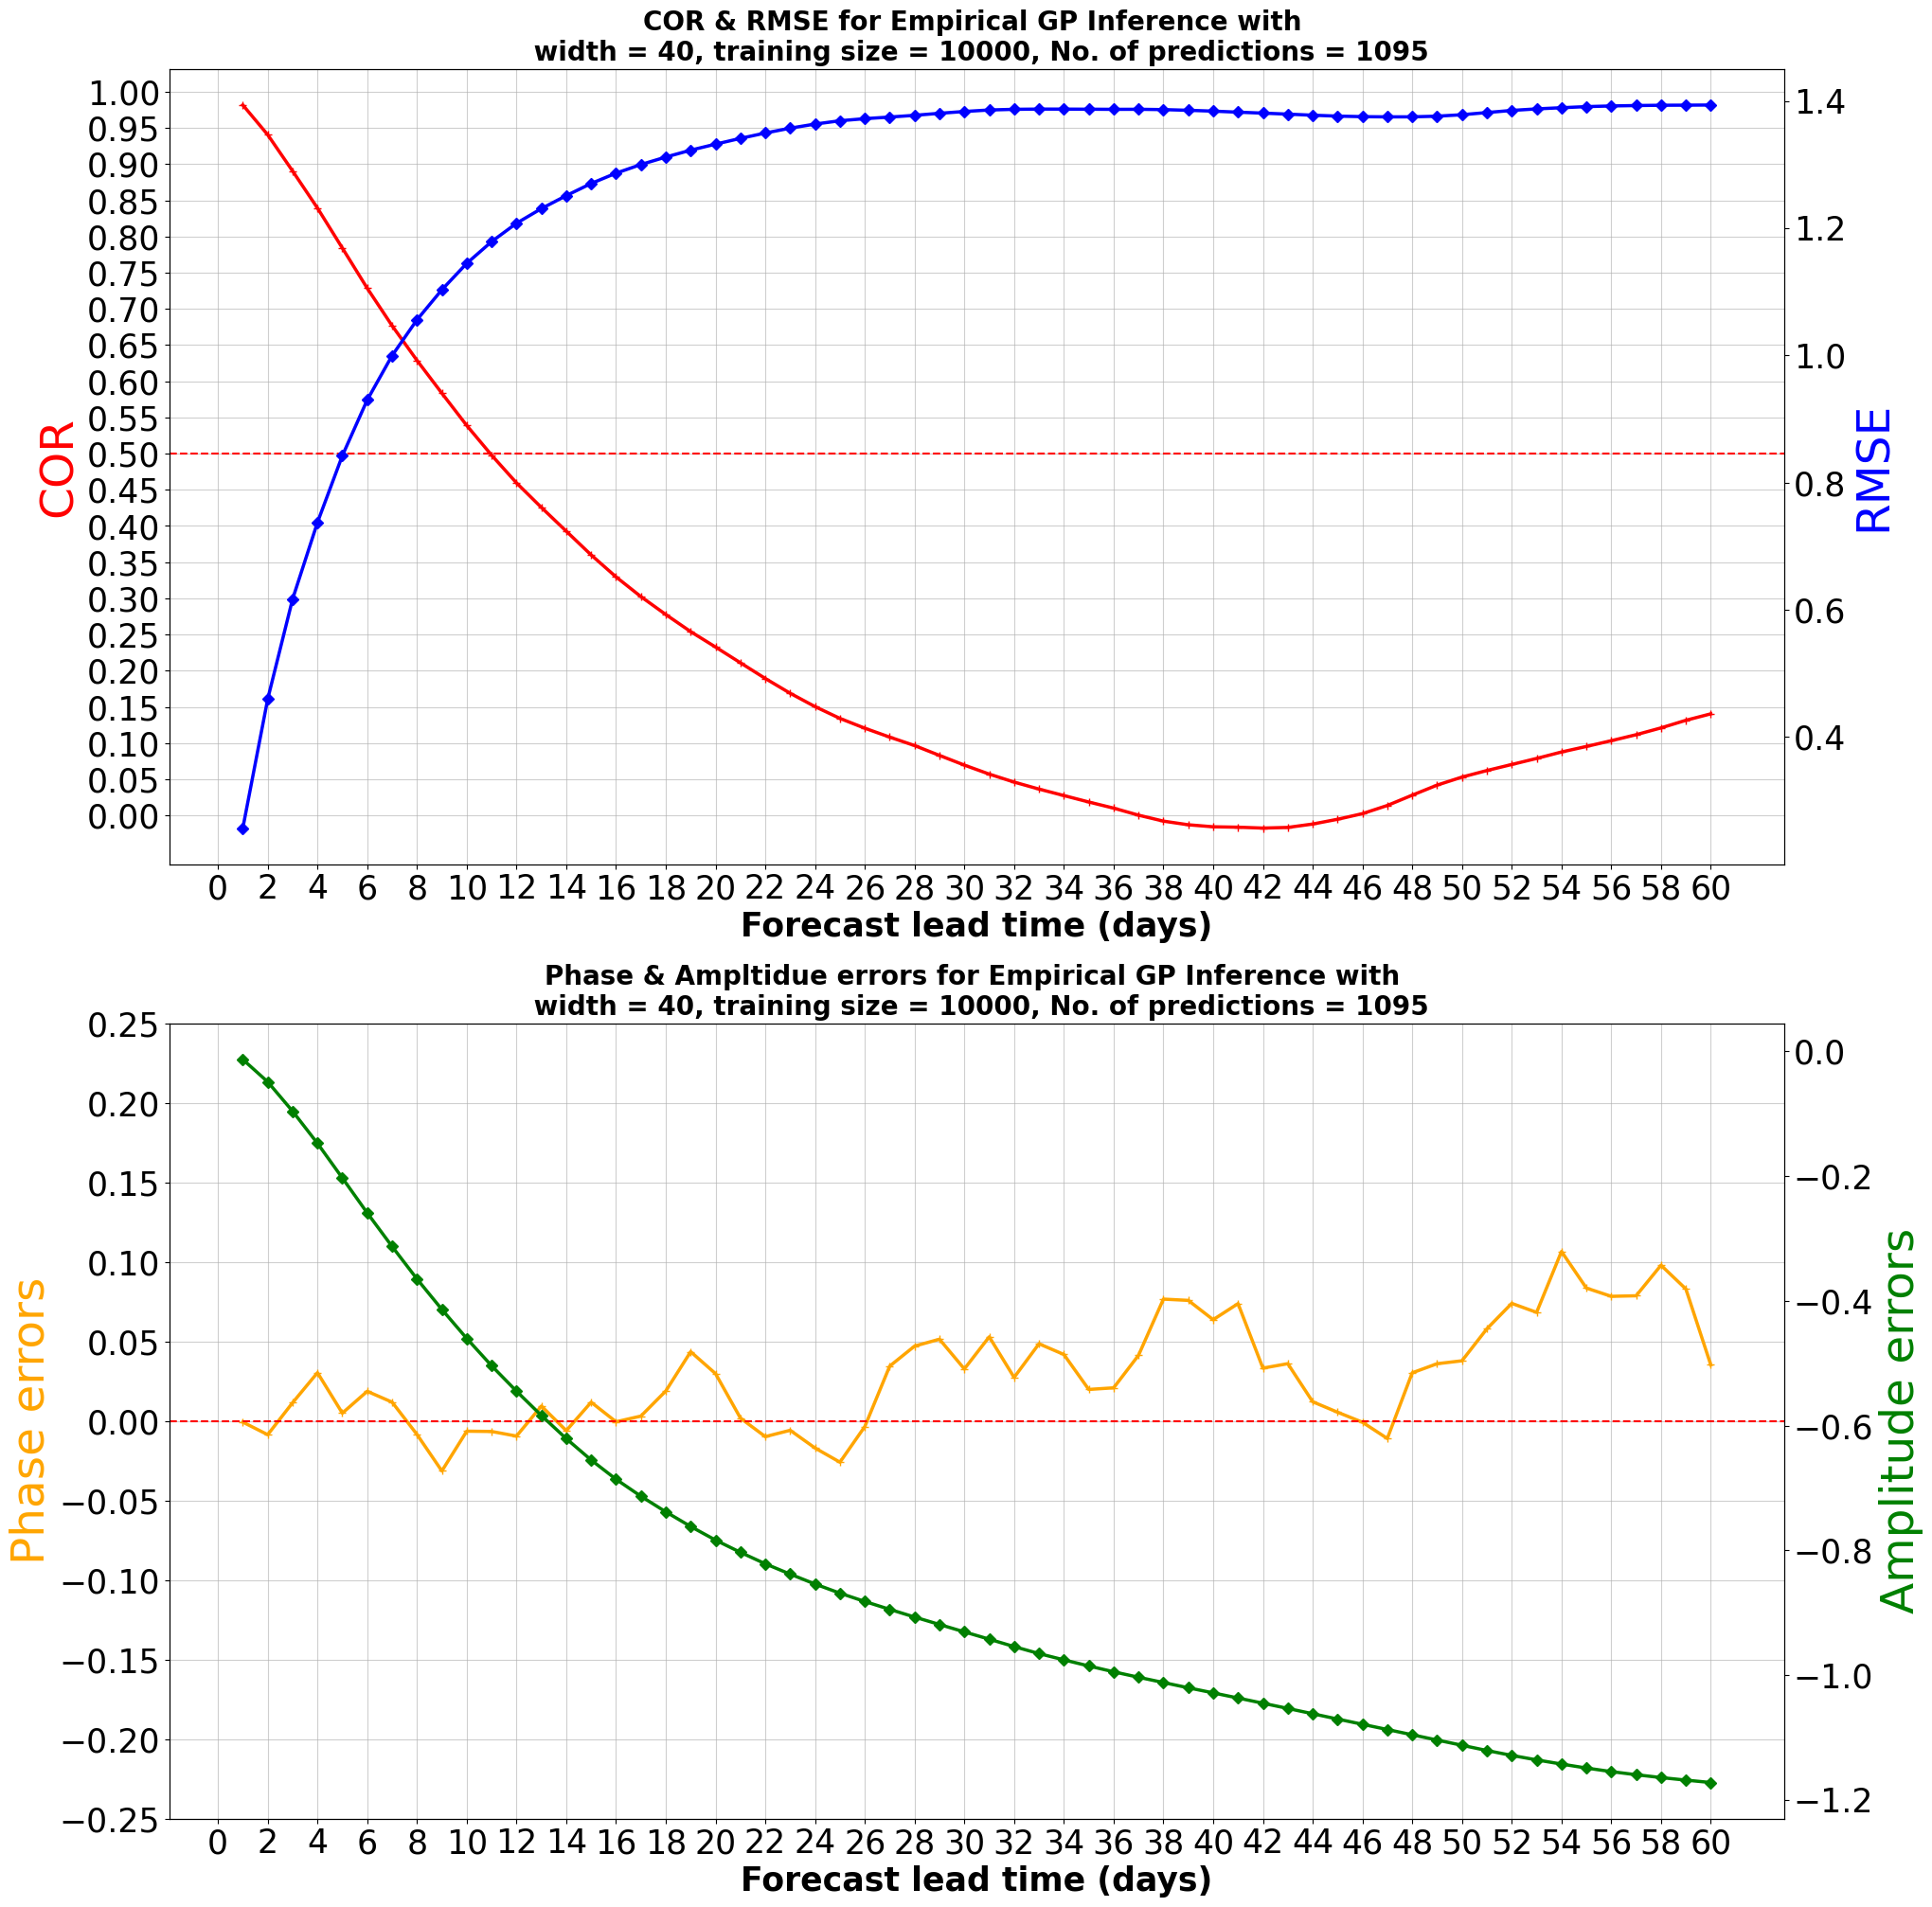

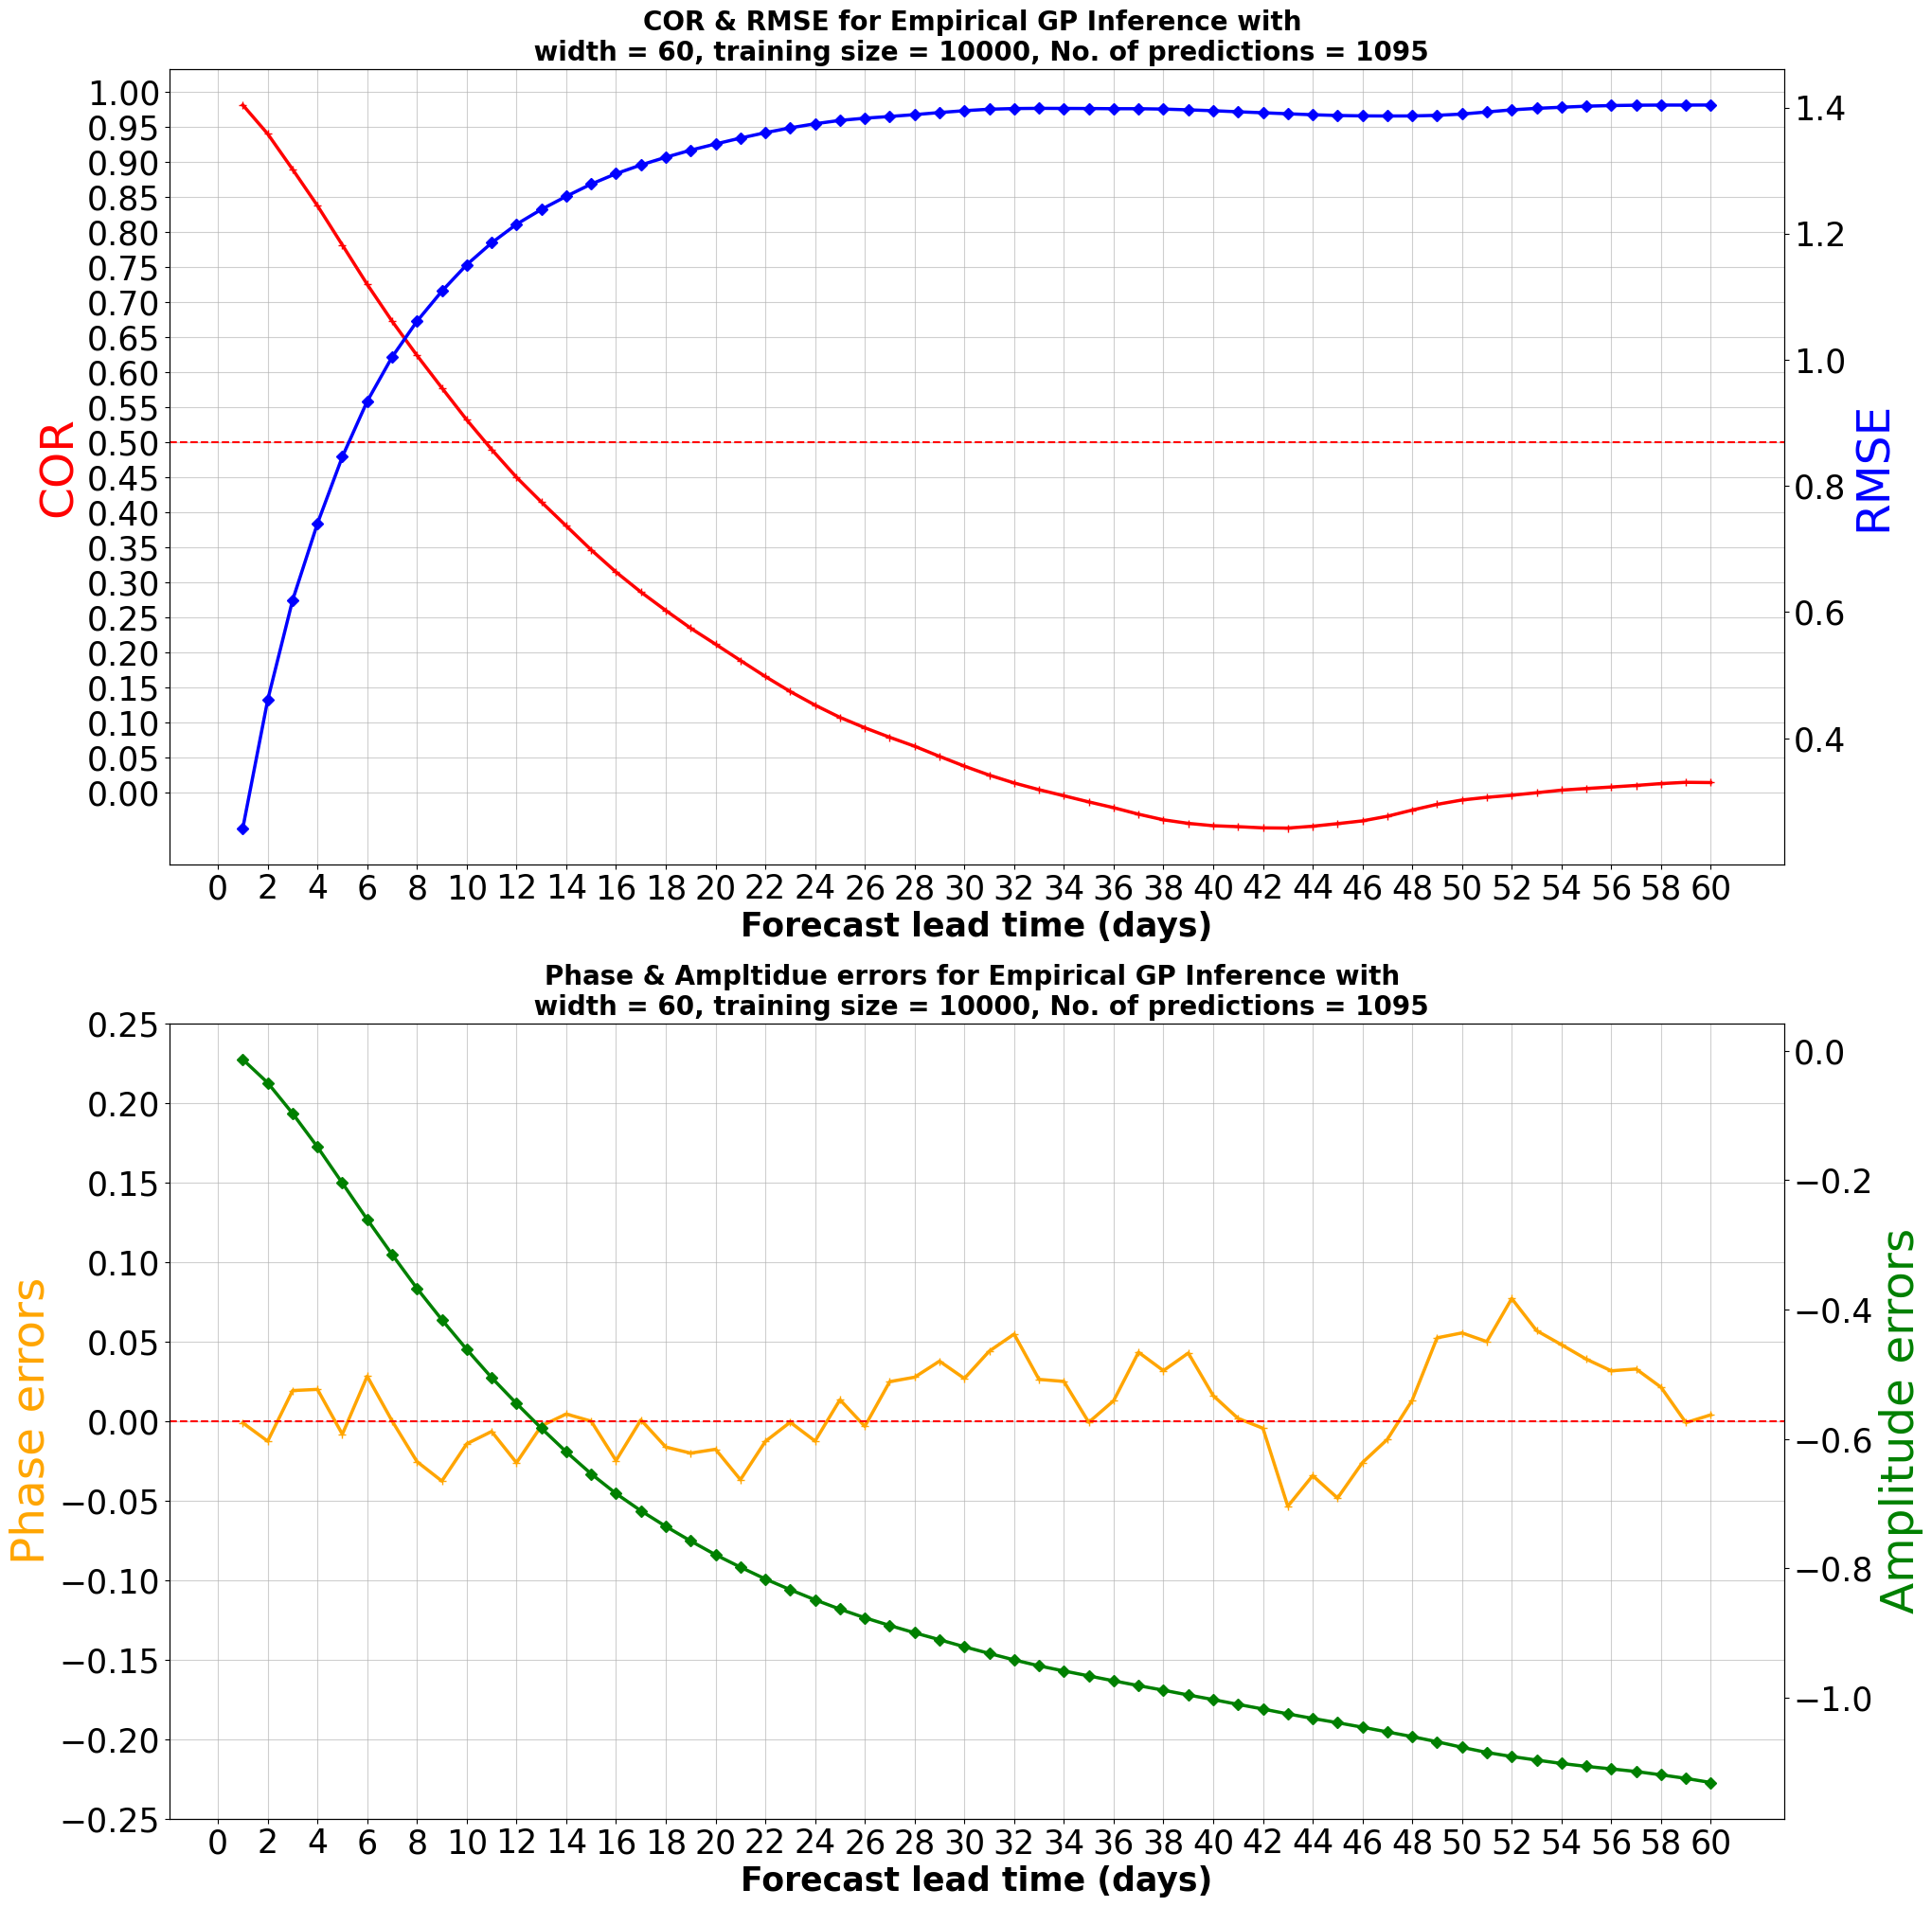

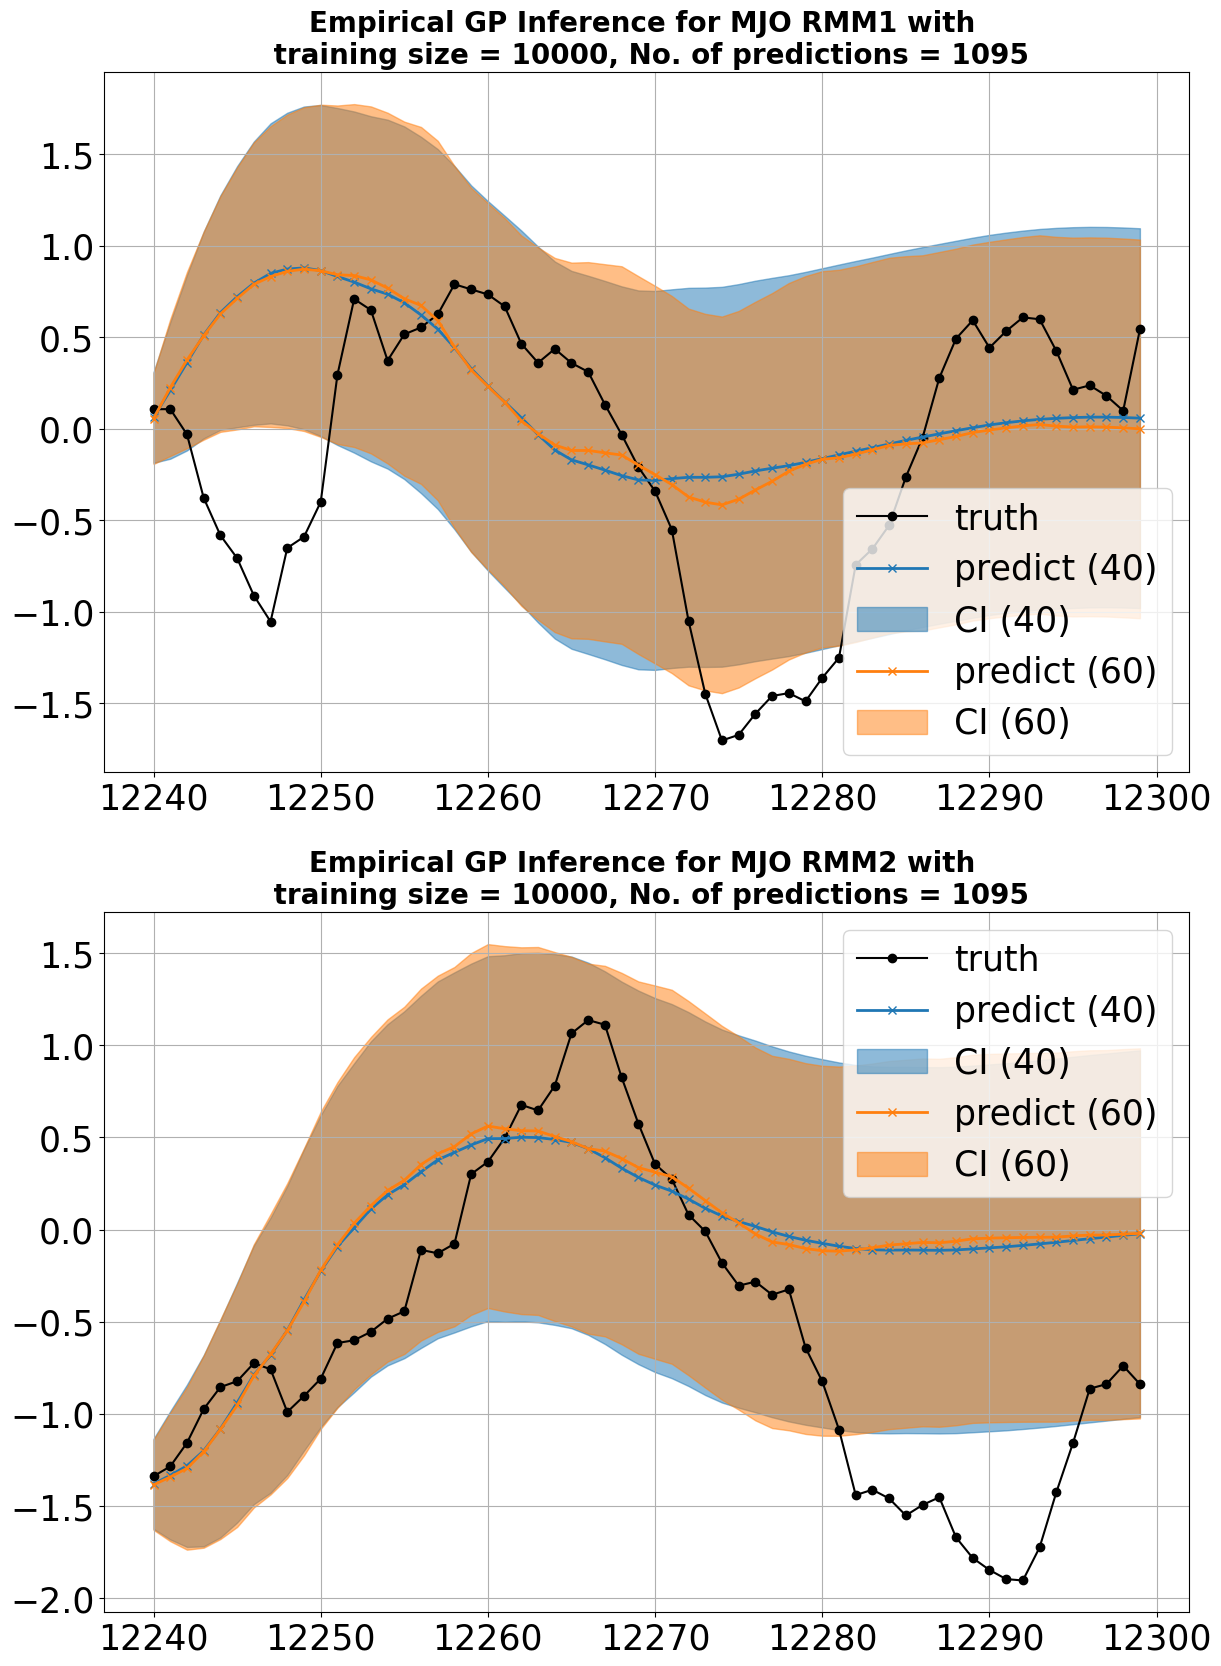

In [5]:
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
colors = palette_colors[0:len(widths)]
rmms = ['RMM1','RMM2']

plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

# Plot auto-correlation and cross-correlation
maxlags = 60
fig, axs = plt.subplots(3, 1, figsize=(14, 10*3))
axs[0].xcorr(entire_npzfile['RMM1'][start_train: start_train+n_trains[widths[0]]], entire_npzfile['RMM2'][start_train: start_train+n_trains[widths[0]]], usevlines=True, normed=True, maxlags=maxlags, lw=2)
axs[0].set_xlabel('Lags', fontsize=25, fontweight='bold')
axs[0].set_title(f'Cross-correlation for  RMMs with maxlags = {maxlags}', fontsize=25)
axs[0].grid(True)
for k, rmm in enumerate(['RMM1','RMM2']):
    axs[k+1].acorr(entire_npzfile[rmm][start_train: start_train+n_trains[widths[0]]], usevlines=True, maxlags=maxlags, normed=True, lw=2)
    axs[k+1].set_xlabel('Lags', fontsize=25, fontweight='bold')
    axs[k+1].set_title(f'Auto-correlation for {rmm} with maxlags = {maxlags}', fontsize=25)
    axs[k+1].grid(True)
fig.savefig("../figs/emp_entire_corrs.png")

for width in widths:

    n_train = n_trains[width]
    start_test = start_tests[width]

    # # Plot cov
    # emp_covs = [K11_entire[width], K22_entire[width]]
    # emp_cov_names = ['K11','K22']
    # fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))
    # for i, emp_cov in enumerate(emp_covs):
    #     axs[i].matshow(emp_cov)
    #     axs[i].set_title(f'{emp_cov_names[i]}', fontsize = 20)
    # fig.savefig("../figs/emp_entire_covs.png")

    # Plot errors
    fig, axs = plt.subplots(2, 1, figsize=(22, 12*2))
    
    # cor & rmse
    ax0 = axs[0].twinx()
    axs[0].plot(np.arange(1,lead_time+1), cor_entire[width], color='red', linewidth=2.5, marker='+')
    axs[0].axhline(y = 0.5, color = 'r', linestyle = '--')
    ax0.plot(np.arange(1,lead_time+1), rmse_entire[width], color='blue', linewidth=2.5, marker='D')

    axs[0].set_xlabel('Forecast lead time (days)', fontsize=25, fontweight="bold")
    axs[0].set_ylabel('COR', color= 'red', fontsize=35)
    axs[0].set_title(f'COR & RMSE for Empirical GP Inference with \n width = {width}, training size = {n}, No. of predictions = {n_pred}', fontsize=20, fontweight="bold")
    ax0.set_ylabel('RMSE', color = 'blue', fontsize=35)

    major_ticks = np.linspace(0, lead_time, 31)
    minor_ticks = np.linspace(0.0, 1.0, 21)
    axs[0].set_xticks(major_ticks)
    axs[0].set_yticks(minor_ticks)
    axs[0].grid(which="major",alpha=0.6)

    # phase err & amplitude err
    ax1 = axs[1].twinx()
    axs[1].plot(np.arange(1,lead_time+1), phase_err_entire[width], color='orange', linewidth=2.5, marker='+')
    axs[1].axhline(y = 0.0, color = 'r', linestyle = '--')
    ax1.plot(np.arange(1,lead_time+1), amplitude_err_entire[width], color='green', linewidth=2.5, marker='D')

    axs[1].set_xlabel('Forecast lead time (days)', fontsize=25, fontweight="bold")
    axs[1].set_ylabel('Phase errors', color='orange', fontsize=35)
    axs[1].set_title(f'Phase & Ampltidue errors for Empirical GP Inference with \n width = {width}, training size = {n}, No. of predictions = {n_pred}', fontsize=20, fontweight="bold")
    ax1.set_ylabel('Amplitude errors', color='green', fontsize=35)
    
    major_ticks = np.linspace(0, lead_time, 31)
    minor_ticks = np.linspace(-0.25, 0.25, 11)
    axs[1].set_xticks(major_ticks)
    axs[1].set_yticks(minor_ticks)
    axs[1].grid(which="major",alpha=0.6)

    fig.savefig("../figs/emp_entire_errs.png")
    plt.show()

 # Plot predictions with observations
for i in range(50,51):#range(n_pred):
    #start_ids = np.arange(i + start_test + 1, i + start_test + width + 1)
    pred_ids = np.arange(i + start_tests[widths[0]] + widths[0], i + start_tests[widths[0]] + widths[0] + lead_time)
    fig, axs = plt.subplots(2, 1, figsize=(14, 10*2))
    for k, rmm in enumerate(rmms):
        #axs[k].plot(start_ids, npzfile[rmm][start_ids], color='black', marker='^')
        axs[k].plot(pred_ids, obs[widths[0]][rmm][i,:], color='black', marker='o')
        for width, color in zip(widths,colors):    
            # Plot predictive means as blue line
            axs[k].plot(pred_ids, observed_preds[width][rmm][i,:], color, linewidth=2, marker='x')
            # shade between the lower and upper confidence bounds
            axs[k].fill_between(pred_ids, lower_confs[width][rmm][i,:], upper_confs[width][rmm][i,:], alpha=0.5, color=color)
        axs[k].legend(['truth', f'predict ({widths[0]})',f'CI ({widths[0]})', f'predict ({widths[1]})',f'CI ({widths[1]})'],fontsize=25)
        axs[k].grid()
        axs[k].set_title(f'Empirical GP Inference for MJO {rmm} with \n training size = {n}, No. of predictions = {n_pred}',fontsize=20, fontweight="bold")
    fig.savefig("../figs/emp_entire_preds.png")
plt.show()

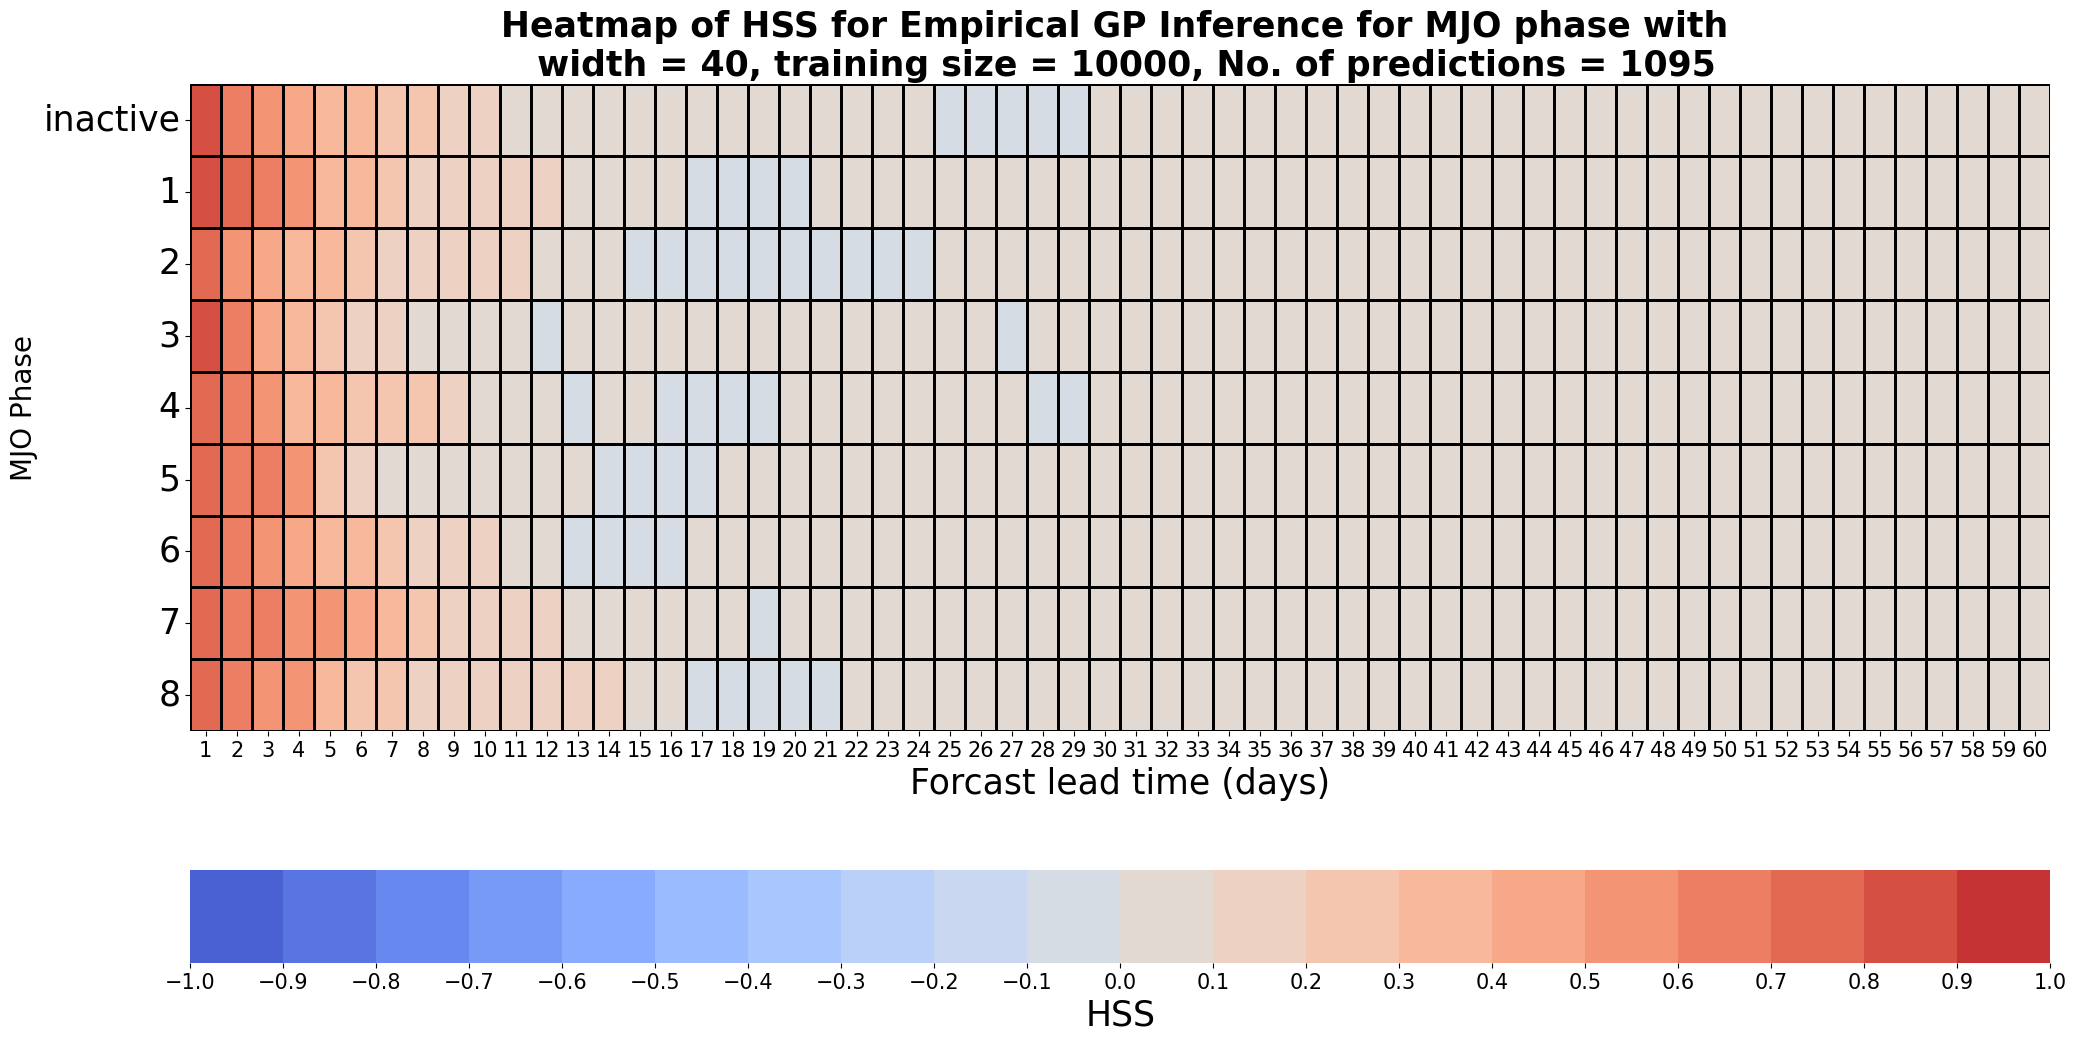

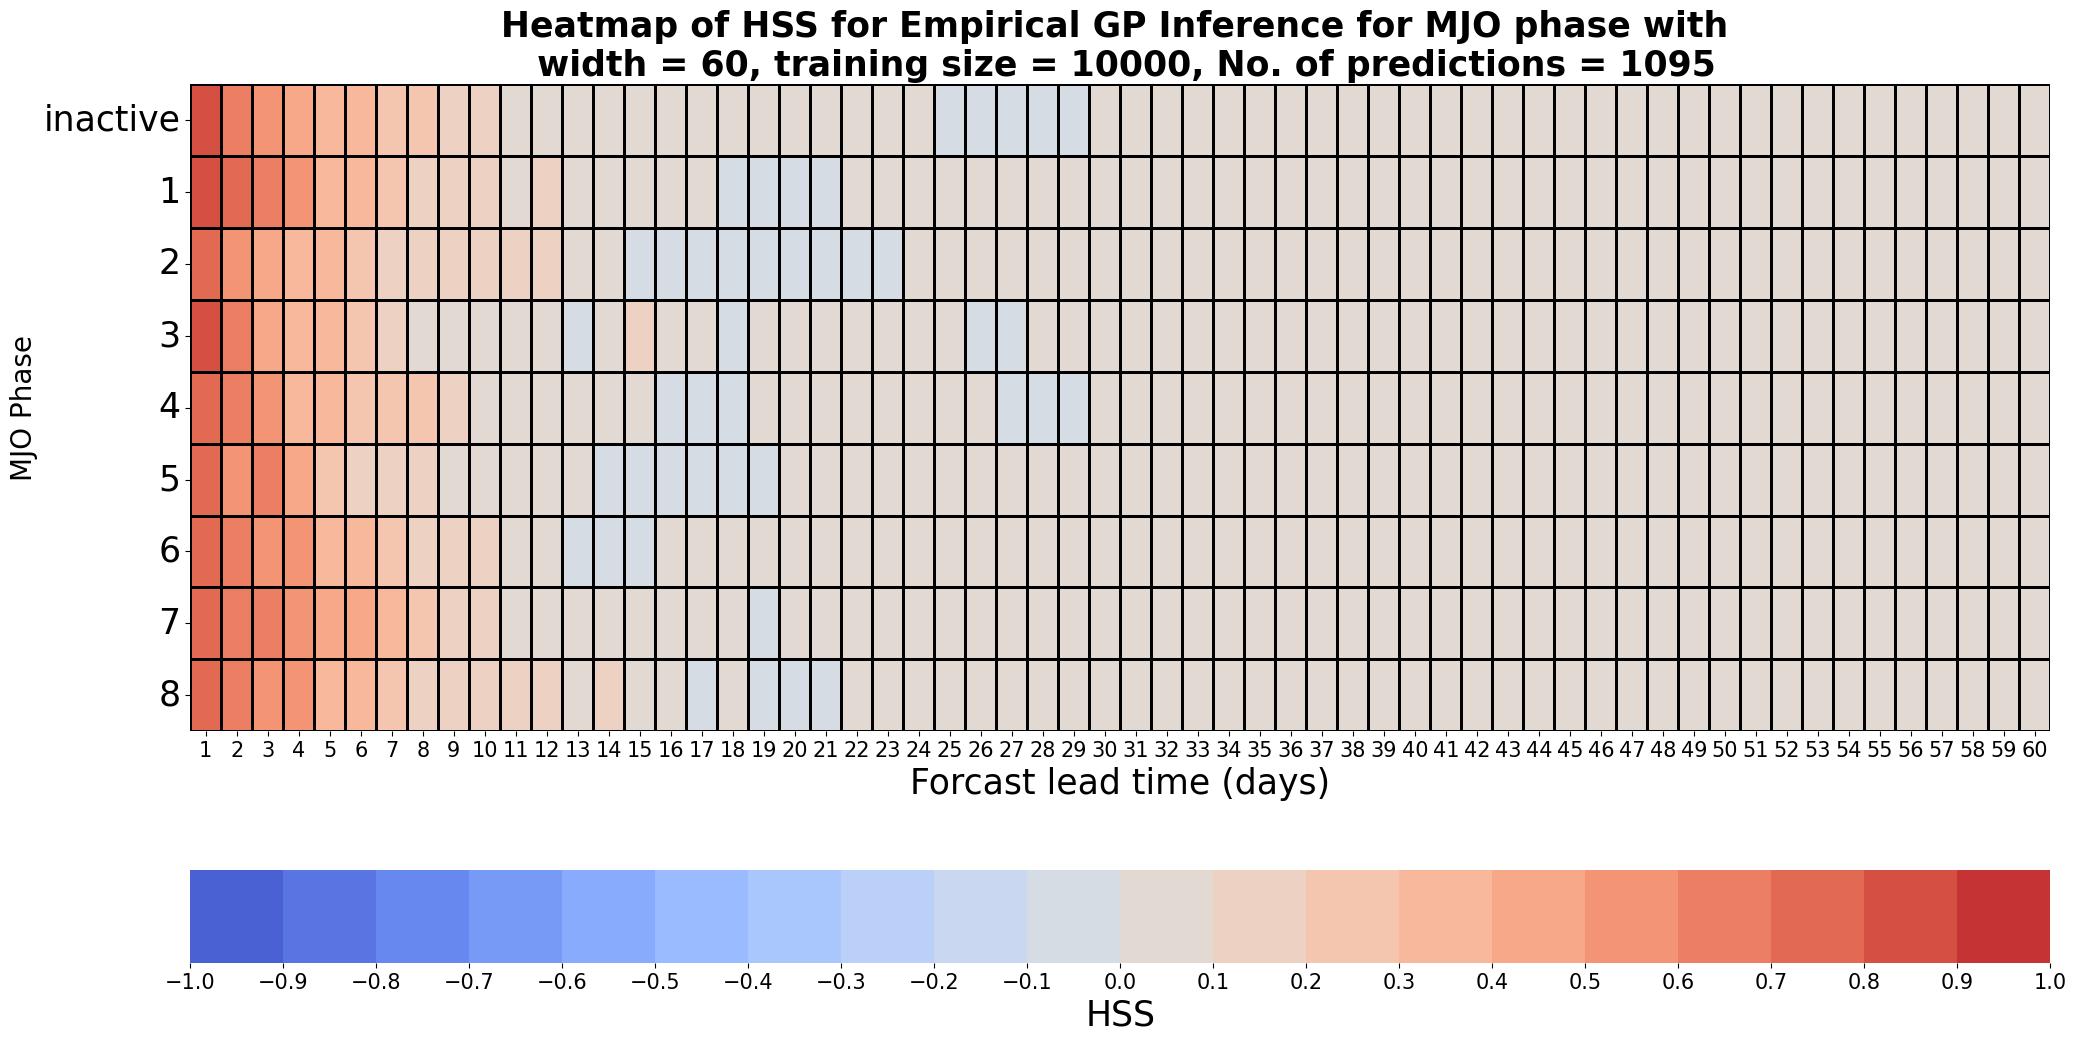

In [6]:
# Plot hss heatmap
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

for width in widths:
    plt.figure(figsize = (24, 12))

    cmap = sns.color_palette("coolwarm", 20)#[::-1]
    # cmap = []*20
    # cmap[:10] = sns.color_palette("icefire", 20)[10:20:1]
    # cmap[10:] = sns.color_palette("icefire", 20)[0:10:1]

    cbar_kws={'label': 'HSS', 'orientation': 'horizontal'}
    xticklabels = np.arange(1, 61)
    yticklabels = ['inactive'] + [i for i in np.arange(1,9)]
    s = sns.heatmap(data=hss_entire[width], vmin=-1, vmax=1, linecolor='black', linewidth=2, cmap=cmap, cbar_kws=cbar_kws,xticklabels=xticklabels,yticklabels=yticklabels)

    colorbar = s.collections[0].colorbar
    colorbar.set_ticks( np.linspace(start=-1, stop=1, num=21, endpoint=True) )
    #colorbar.set_ticklabels(['B', 'A', 'C'])

    s.set_xlabel('Forcast lead time (days)', fontsize=25)
    s.set_ylabel('MJO Phase', fontsize=20)
    s.figure.axes[-1].xaxis.label.set_size(25)
    s.figure.axes[-1].set_xlabel('HSS', size=25)
    s.set_title(f'Heatmap of HSS for Empirical GP Inference for MJO phase with \n width = {width}, training size = {n}, No. of predictions = {n_pred}', fontsize=25, fontweight="bold")
    plt.savefig("../figs/emp_entire_hss.png")

plt.show()

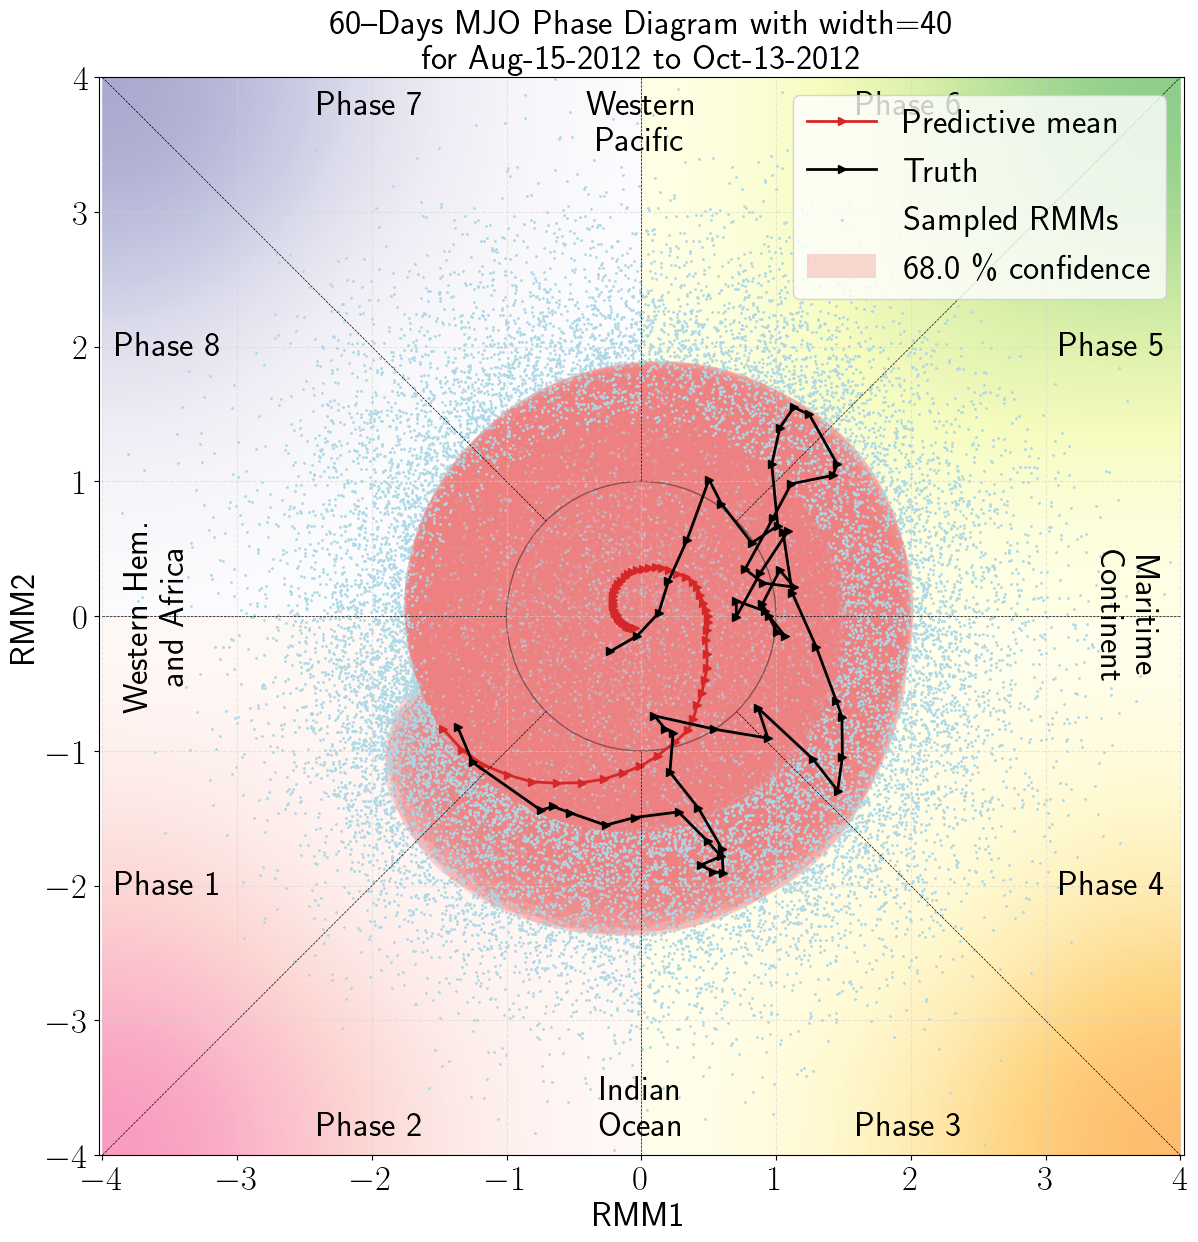

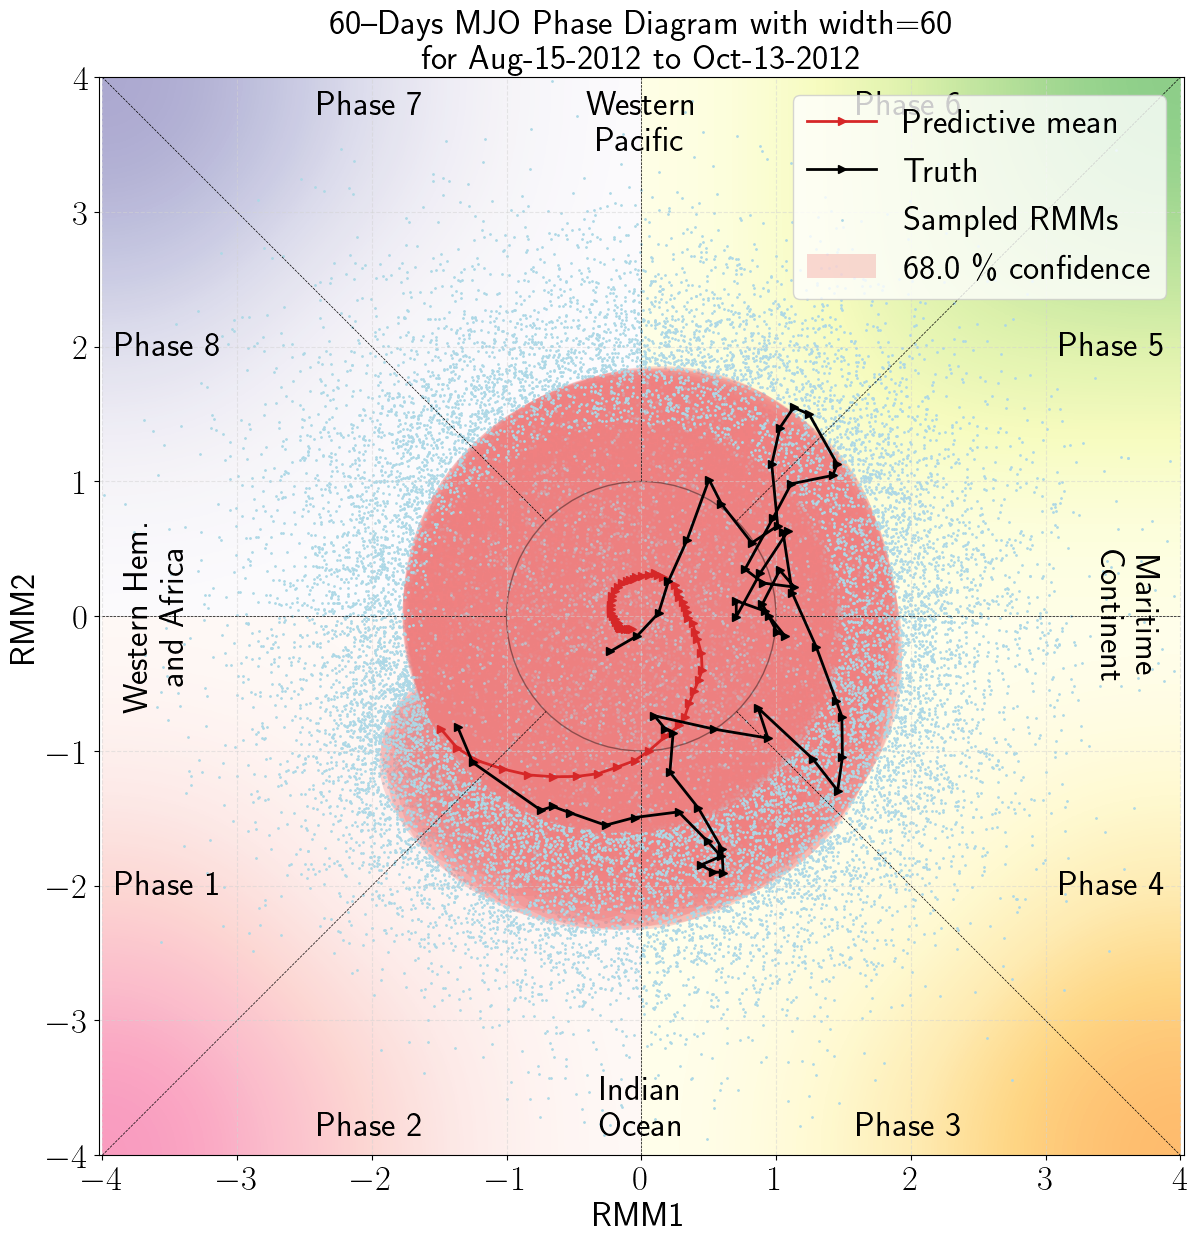

In [135]:
palette_colors = list(mcolors.TABLEAU_COLORS.keys())

# plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

Ns = 1000
pred_id = 90
lead_time = 60

p = 2
alpha = 1-0.68
s = chi2.isf(alpha, p) # scale of the ellipse using the inverse cumulative distrubution function

for width in widths:

    start_year = obs[width]['year'][pred_id, 0].astype('int')
    start_month = calendar.month_abbr[ obs[width]['month'][pred_id, 0].astype('int') ]
    start_day = obs[width]['day'][pred_id, 0].astype('int')
    start_date =  f'{start_month}-{start_day:02d}-{start_year}'

    end_year = obs[width]['year'][pred_id, lead_time-1].astype('int')
    end_month = calendar.month_abbr[ obs[width]['month'][pred_id,lead_time-1].astype('int') ]
    end_day = obs[width]['day'][pred_id, lead_time-1].astype('int')
    end_date =  f'{end_month}-{end_day:02d}-{end_year}'

    fig, ax = plt.subplots(1, 1, figsize=(14, 14))

    ax.plot(observed_preds[width]['RMM1'][pred_id, :lead_time], observed_preds[width]['RMM2'][pred_id, :lead_time], '->', color=palette_colors[3], linewidth=2, label="Predictive mean")
    ax.plot(obs[width]['RMM1'][pred_id, :lead_time], obs[width]['RMM2'][pred_id, :lead_time], '->', color='black', linewidth=2, label="Truth")

    for j in range(lead_time):
        pred_mean = np.array( [ observed_preds[width]['RMM1'][pred_id, j] , observed_preds[width]['RMM2'][pred_id, j] ] ) # (2, ) array
        true_mean = np.array( [ obs[width]['RMM1'][pred_id, j] , obs[width]['RMM2'][pred_id, j] ] ) # (2, ) array
        pred_cov = emp_model.Kcond_correct[j] # (2, 2) array
        rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
        rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
        rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

        eig_vals, eig_vecs = np.linalg.eig(pred_cov)
        eig_id_max = np.argmax(eig_vals)
        eig_id_min = np.argmin(eig_vals)

        ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="Sampled RMMs")
        # ax.plot(pred_mean[0], pred_mean[1], '->', color='red', linewidth=2, label="Predictive mean")
        # ax.plot(true_mean[0], true_mean[1], '->', color='black', linewidth=2, label="Truth")
        #first_legend = plt.legend(loc="upper left")
        ell = patches.Ellipse(
            xy = (pred_mean[0], pred_mean[1]),
            width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
            height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
            angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
            alpha = 0.3,
            facecolor = 'lightcoral'
        )
        ax.add_patch(ell)
        if j == 0:
            ax.legend([ "Predictive mean", "Truth", "Sampled RMMs", str(100 * (1 - alpha)) + " \% confidence"], fontsize=25)

    # lines to separate the phases  
    ax.plot([-4,-1/np.sqrt(2)],[-4,-1/np.sqrt(2)],linewidth=0.5,linestyle='dashed',color='k')
    ax.plot([1/np.sqrt(2),4],[1/np.sqrt(2),4],linewidth=0.5,linestyle='--',color='k')
    ax.plot([-4,-1/np.sqrt(2)],[4,1/np.sqrt(2)],linewidth=0.5,linestyle='--',color='k')
    ax.plot([1/np.sqrt(2),4],[-1/np.sqrt(2),-4],linewidth=0.5,linestyle='--',color='k')
    ax.plot([-4,-1],[0,0],linewidth=0.5,linestyle='--',color='k')
    ax.plot([1,4],[0,0],linewidth=0.5,linestyle='--',color='k')
    ax.plot([0,0],[-4,-1],linewidth=0.5,linestyle='--',color='k')
    ax.plot([0,0],[1,4],linewidth=0.5,linestyle='--',color='k')
    ax.set(xlim =(-4.0, 4.0), 
            ylim =(-4.0, 4.0), 
            autoscale_on = False)


    # circle in the center of the plot to denote weak index  
    circle = patches.Circle((0, 0), radius=1.0, fc='k', ec='k', alpha=0.4, fill=False)
    ax.add_patch(circle)


    # text for phases
    ax.text(0.0, 3.9, "Western \n Pacific", horizontalalignment='center', verticalalignment='top',
    fontsize=25) #transform=ax.transAxes, 
    ax.text(-2, 3.9, "Phase 7", horizontalalignment='center', verticalalignment='top',
    fontsize=25, fontweight='bold')
    ax.text(2, 3.9, "Phase 6", horizontalalignment='center', verticalalignment='top',
    fontsize=25, fontweight='bold')

    ax.text(0.0, -3.9, "Indian \n Ocean", horizontalalignment='center', verticalalignment='bottom',
    fontsize=25)
    ax.text(-2, -3.9, "Phase 2", horizontalalignment='center', verticalalignment='bottom',
    fontsize=25, weight='bold')#transform=ax.transAxes, 
    ax.text(2, -3.9, "Phase 3", horizontalalignment='center', verticalalignment='bottom',
    fontsize=25, weight='bold')

    ax.text(3.6, 0.0, "Maritime \n Continent", horizontalalignment='center', verticalalignment='center',
    rotation=-90, fontsize=25)
    ax.text(3.9, 2, "Phase 5", horizontalalignment='right', verticalalignment='center',
    fontsize=25)
    ax.text(3.9, -2, "Phase 4", horizontalalignment='right', verticalalignment='center',
    fontsize=25)

    ax.text(-3.6, 0.0, "Western Hem. \n and Africa", horizontalalignment='center', verticalalignment='center',
    rotation=90, fontsize=25)
    ax.text(-3.9, -2, "Phase 1", horizontalalignment='left', verticalalignment='center',
    fontsize=25, weight='bold')
    ax.text(-3.9, 2, "Phase 8", horizontalalignment='left', verticalalignment='center',
    fontsize=25, weight='bold')

    m_right_top = np.array([[0, 0.25, 0.5], [0, 0.25, 0.25], [0, 0, 0]])
    ax.imshow(m_right_top,
          cmap=plt.cm.YlGn,
          interpolation='bicubic',
          extent=plt.xlim(0,4) + plt.ylim(0,4), vmin=0, vmax=1, alpha=0.9)
    
    m_right_bottom = np.array([[0, 0, 0], [0, 0, 0.25], [0, 0.25, 0.5]])
    ax.imshow(m_right_bottom,
          cmap=plt.cm.YlOrBr,
          interpolation='bicubic',
          extent=plt.xlim(0,4) + plt.ylim(-4,0), vmin=0, vmax=1, alpha=0.7)
    
    m_left_top = np.array([[0.5, 0.25, 0], [0.25, 0, 0], [0, 0, 0]])
    ax.imshow(m_left_top,
          cmap=plt.cm.Purples,
          interpolation='bicubic',
          extent=plt.xlim(-4,0) + plt.ylim(0,4), vmin=0, vmax=1, alpha=0.9)
    
    m_left_bottom = np.array([[0, 0, 0], [0.25, 0, 0], [0.5, 0.25, 0]])
    ax.imshow(m_left_bottom,
          cmap=plt.cm.RdPu,
          interpolation='bicubic',
          extent=plt.xlim(-4,0) + plt.ylim(-4,0), vmin=0, vmax=1, alpha=0.7)

    ax.axis("equal")
        #ax = plt.gca().add_artist(first_legend)
    ax.set_xlabel('RMM1', fontsize=25)
    ax.set_ylabel('RMM2', fontsize=25)
    ax.set_title(f'{lead_time}--Days MJO Phase Diagram with width={width} \n for {start_date} to {end_date}', fontsize=25, fontweight="bold")
    ax.grid(color='lightgrey', linestyle='dashed', alpha=0.5)
    plt.show()


## Season

In [ ]:
## Divide new_datas into four seasons
npz_month = npzfile['month']
fall_winter_ids = np.where( (npz_month==9) | (npz_month==10) | (npz_month==11) | (npz_month==12) | (npz_month==1) | (npz_month==2) )[0]
spring_summer_ids = np.where( (npz_month==3) | (npz_month==4) | (npz_month==5) | (npz_month==6) | (npz_month==7) | (npz_month==8) )[0]
#summer_ids = np.where( (npz_month==6) | (npz_month==7) | (npz_month==8) )[0]
#fall_ids = np.where( (npz_month==9) | (npz_month==10) | (npz_month==11) )[0]

print(npz_month.shape)
print(fall_winter_ids.shape)
print(spring_summer_ids.shape)
# print(summer_ids.shape)
# print(fall_ids.shape)

#========================================================
# create season dataset
#========================================================
seasons = ['fall_winter','spring_summer']
seasons_ids = [fall_winter_ids, spring_summer_ids]
data_names = npzfile.files + ['id']
n_files = len(data_names)

season_npzfile = {}
for j in range(2):
    season = seasons[j]
    season_id = seasons_ids[j]

    new_npzfile = {} #[0]*n_files
    for i, data_name in enumerate(data_names):
        if i < n_files-1:
            new_npzfile[data_name] = npzfile[data_name][season_id]
        if i == n_files-1:
            new_npzfile[data_name] = season_id

    season_npzfile[season] = new_npzfile

(16026,)
(7930,)
(8096,)


In [ ]:
Ns = [len(fall_winter_ids),len(spring_summer_ids)]# the total number of days in new dataset
n = 5000 # the number of days for training
ms = [N-n-365 for N in Ns] # the number of days for testing
print(ms)

width = 40
lead_time = 60
start_train = 0
n_offset = 0
n_pred = 365*3

n_train = width + n
start_test = start_train + n_train + n_offset

train_rmms = {}

dist_joint = {}
train_jointcov = {}

pred_ids = {}
obs = {}
observed_preds = {}
lower_confs = {}
upper_confs = {}

cor_season = {}
rmse_season = {}
phase_err_season = {}
amplitude_err_season = {}
hss_season = {}

K11_season = {}
K22_season = {}

for m, season in zip(ms, seasons):
    emp_model = emp_gp_mjo(npzfile=season_npzfile[season], width=width, n=n, start_train=start_train, season_bool=True)
    emp_model.get_emp()
    emp_model.pred(start_test=start_test, lead_time=lead_time, n_pred=n_pred, m=m, season_bool=True)

    train_rmms[season] = emp_model.train_rmms
    
    # compute errors
    cor_season[season] = emp_model.cor()
    rmse_season[season] = emp_model.rmse()
    phase_err_season[season] = emp_model.phase_err()
    amplitude_err_season[season] = emp_model.amplitude_err()
    hss_season[season] = emp_model.hss()

    # cov
    K11_season[season] = emp_model.K11
    K22_season[season] = emp_model.K22

    dist_joint[season] = emp_model.dist_joint
    train_jointcov[season] = emp_model.train_jointcov

    # preds
    pred_ids[season] = emp_model.pred_ids
    obs[season] = emp_model.obs
    observed_preds[season] = emp_model.observed_preds
    lower_confs[season] = emp_model.lower_confs
    upper_confs[season] = emp_model.upper_confs

[2565, 2731]
the number of predictions is greater than the number of the season intervals..., will set n_pred = 1085


/var/folders/51/_9h2_qzn4b54cgs0qgwxr0vh0000gn/T/ipykernel_73472/2001795459.py:284: RuntimeWarning: invalid value encountered in divide
  self.errs['cor'] = (numerator / denominator).reshape(-1) # shape = (lead_time,) numpy array
/var/folders/51/_9h2_qzn4b54cgs0qgwxr0vh0000gn/T/ipykernel_73472/2001795459.py:315: RuntimeWarning: invalid value encountered in divide
  temp = np.arctan(np.divide(num,den))
/var/folders/51/_9h2_qzn4b54cgs0qgwxr0vh0000gn/T/ipykernel_73472/2001795459.py:284: RuntimeWarning: invalid value encountered in divide
  self.errs['cor'] = (numerator / denominator).reshape(-1) # shape = (lead_time,) numpy array
/var/folders/51/_9h2_qzn4b54cgs0qgwxr0vh0000gn/T/ipykernel_73472/2001795459.py:315: RuntimeWarning: invalid value encountered in divide
  temp = np.arctan(np.divide(num,den))


In [ ]:
seasons = ['fall_winter','spring_summer']
season_months = ['fall_winter(SONDJF)','spring_summer(MAMJJA)']
plot_colors = ['tab:blue','tab:green']#,'tab:red','tab:orange']

plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

# Plot cov
emp_season_covs = [K11_season, K22_season]
emp_cov_names = ['K11','K22']
for season, season_month in zip(seasons, season_months):
    fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))
    for i, emp_season_cov in enumerate(emp_season_covs):
        axs[i].matshow(emp_season_cov[season])
        axs[i].set_title(f'{emp_cov_names[i]} in {season_month}', fontsize = 20)
    fig.savefig(f'../figs/emp_{season}_covs')

# Plot auto-correlation and cross-correlation
maxlags = 60
for season, season_month, color in zip(seasons, season_months, plot_colors):
    start_id_season = ( np.where(np.ediff1d(season_npzfile[season]['id']) != 1 )[0]+1 )[2]
    n_train_rmm = len(train_rmms[season]) // 2
    fig, axs = plt.subplots(3, 1, figsize=(14, 10*3))
    for k, rmm in enumerate(['RMM1','RMM2']):
        rmm_data = train_rmms[season][:n_train_rmm] if k == 0 else train_rmms[season][n_train_rmm:]
        axs[k].acorr(train_rmms[season][:n_train_rmm], usevlines=True, maxlags=maxlags, normed=True, lw=2, color=color)
        #axs[k].acorr(season_npzfile[season][rmm][start_id_season: start_id_season+90], usevlines=True, maxlags=maxlags, normed=True, lw=2, color=color)
        axs[k].set_xlabel('Lags', fontsize=25, fontweight='bold')
        axs[k].set_title(f'Auto-correlation for {rmm} in {season_month} with maxlags = {maxlags}', fontsize=25)
        axs[k].grid(True)
    axs[2].xcorr(train_rmms[season][:n_train_rmm], train_rmms[season][n_train_rmm:], usevlines=True, normed=True, maxlags=maxlags, lw=2, color=color)
    #axs[2].xcorr(season_npzfile[season]['RMM1'][start_id_season: start_id_season+90], season_npzfile[season]['RMM2'][start_id_season: start_id_season+90], usevlines=True, normed=True, maxlags=maxlags, lw=2, color=color)
    axs[2].set_xlabel('Lags', fontsize=25, fontweight='bold')
    axs[2].set_title(f'Cross-correlation for RMMs in {season_month} with maxlags = {maxlags}', fontsize=25)
    axs[2].grid(True)
    
    fig.savefig(f'../figs/emp_{season}_corrs')

plt.show()

In [ ]:
from matplotlib.markers import MarkerStyle
mjo_errs = ['COR', 'RMSE', 'Phase error', 'Amplitude error']
seasons = ['fall_winter','spring_summer']
season_months = ['fall_winter(SONDJF)','spring_summer(MAMJJA)']#,'summer(JJA)','fall(SON)']
plot_colors = ['tab:blue','tab:green']#,'tab:red','tab:orange']
dark_colors = ['darkblue','darkgreen']#,'darkred','darkorange']
markers_class = list(MarkerStyle.markers.keys())
plot_markers = markers_class[2:2+len(seasons)]
rmms = ['RMM1','RMM2']

plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
# Plot errors
fig, axs = plt.subplots(2, 2, figsize=(28*2, 18*2))
for season, color, marker in zip(seasons, plot_colors, plot_markers):
    _cor = cor_season[season]
    _rmse = rmse_season[season]
    _phase_err = phase_err_season[season]
    _amplitude_err = amplitude_err_season[season]
    
    
    axs[0,0].plot(np.arange(1,lead_time+1), _cor, color=color, linewidth=3.5, marker=marker)
    axs[0,1].plot(np.arange(1,lead_time+1), _rmse, color=color, linewidth=3.5, marker=marker)
    axs[1,0].plot(np.arange(1,lead_time+1), _phase_err, color=color, linewidth=3.5, marker=marker)
    axs[1,1].plot(np.arange(1,lead_time+1), _amplitude_err, color=color, linewidth=3.5, marker=marker)

    # cor
    major_ticks = np.linspace(0, lead_time, 31)
    minor_ticks = np.linspace(0., 1.0, 11)
    axs[0,0].set_xticks(major_ticks)
    axs[0,0].set_yticks(minor_ticks)
    axs[0,0].grid(which="major",alpha=0.8)

    # rmse
    major_ticks = np.linspace(0, lead_time, 31)
    minor_ticks = np.linspace(0.2, 1.7, 16)
    axs[0,1].set_xticks(major_ticks)
    axs[0,1].set_yticks(minor_ticks)
    axs[0,1].grid(which="major",alpha=0.8)
    
    # phase err
    major_ticks = np.linspace(0, lead_time, 31)
    minor_ticks = np.linspace(-0.4, 0.1, 11)
    axs[1,0].set_xticks(major_ticks)
    axs[1,0].set_yticks(minor_ticks)
    axs[1,0].grid(which="major",alpha=0.8)

    # amplitude err
    major_ticks = np.linspace(0, lead_time, 31)
    minor_ticks = np.linspace(-1.5, 0.0, 16)
    axs[1,1].set_xticks(major_ticks)
    axs[1,1].set_yticks(minor_ticks)
    axs[1,1].grid(which="major",alpha=0.8)

index = [(0,0),(0,1),(1,0),(1,1)]
for i, mjo_err in enumerate(mjo_errs):
    axs[index[i]].set_xlabel('Forecast lead time (days)', fontsize=35, fontweight="bold")
    axs[index[i]].legend(season_months, fontsize=50)
    axs[index[i]].set_title(f'{mjo_err} for Empirical GP Inference with \n width = {width}, training size = {n}, No. of predictions = {n_pred}', fontsize=35, fontweight="bold")


axs[0,0].axhline(y = 0.5, color = 'r', linestyle = '--')
axs[0,1].axhline(y = 1.4, color = 'r', linestyle = '--')
axs[1,0].axhline(y = 0.0, color = 'r', linestyle = '--')
axs[1,1].axhline(y = 0.0, color = 'r', linestyle = '--')

fig.savefig(f'../figs/emp_season_errs')


# Plot predictions with observations
test_ids = np.arange(start_test, start_test + max(ms))
for i in range(1):#range(n_pred):
    # start_ids = np.arange(i + start_test + width + 1 - width, i + start_test + width + 1)
    # pred_ids = np.arange(i + start_test + width, i + start_test + width + lead_time)
    start_ids = np.arange(season_npzfile[season]['id'][test_ids[pred_ids[season][i]]], season_npzfile[season]['id'][test_ids[pred_ids[season][i]+width+1]])
    pred_ids_season = np.arange(season_npzfile[season]['id'][test_ids[pred_ids[season][i]+width]], season_npzfile[season]['id'][test_ids[pred_ids[season][i]+width+lead_time]])
    for rmm in rmms:
        fig, axs = plt.subplots(len(seasons), 1, figsize=(14, 10*len(seasons)))
        for k, season in enumerate(seasons):
            color = plot_colors[k]
            darkcolor = dark_colors[k]
            season_month = season_months[k]
            axs[k].plot(np.arange(width+1), season_npzfile[season][rmm][test_ids[pred_ids[season][i]: pred_ids[season][i]+width+1]], color=darkcolor, marker='^')
            axs[k].plot(np.arange(width, width+lead_time), obs[season][rmm][i,:], color=darkcolor, marker='o')
            # Plot predictive means as blue line
            axs[k].plot(np.arange(width, width+lead_time), observed_preds[season][rmm][i,:], color=color, linewidth=2, marker='x')
            # shade between the lower and upper confidence bounds
            axs[k].fill_between(np.arange(width, width+lead_time), lower_confs[season][rmm][i,:], upper_confs[season][rmm][i,:], alpha=0.5, color=color)
        
            axs[k].legend(['starting interval', 'truth', 'predict', 'confidence'],fontsize=30)
            axs[k].set_title(f'Empirical GP Inference for MJO {rmm} in {season_month} with \n width = {width}, training size = {n}, No. of predictions = {n_pred}',fontsize=25)

        fig.savefig(f"../figs/emp_season_{rmm}_preds.png")

# Plot covariance versus Euclidean distance
plt.figure(figsize=(12,8))
for season, season_month, color in zip(seasons, season_months, plot_colors):
    iu = np.triu_indices(len(dist_joint[season]))
    dist_joint_unfold = dist_joint[season][iu]
    emp_jointcov_unfold = train_jointcov[season][iu]
    # print(dist_joint_unfold.shape)
    # print(emp_jointcov_unfold.shape)

    arrind = dist_joint_unfold.argsort()
    sorted_dist_joint = dist_joint_unfold[arrind]
    sorted_emp_jointcov = emp_jointcov_unfold[arrind]

    plt.plot(sorted_dist_joint, sorted_emp_jointcov, color=color)
plt.legend(season_months, fontsize=18)
plt.xlabel('Euclidean distance', fontsize=18)
plt.title(f'Empirical covaraince', fontsize=18, fontweight="bold")
plt.show()

In [ ]:
# Plot hss heatmap
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

seasons = ['fall_winter','spring_summer']
season_months = ['fall_winter(SONDJF)','spring_summer(MAMJJA)']#,'summer(JJA)','fall(SON)']

for season, season_month in zip(seasons, season_months):
    plt.figure(figsize = (24, 12))

    cmap = sns.color_palette("coolwarm", 20)#[::-1]
    # cmap = []*20
    # cmap[:10] = sns.color_palette("icefire", 20)[10:20:1]
    # cmap[10:] = sns.color_palette("icefire", 20)[0:10:1]

    cbar_kws={'label': 'HSS', 'orientation': 'horizontal'}
    xticklabels = np.arange(1, 61)
    yticklabels = ['inactive'] + [i for i in np.arange(1,9)]
    s = sns.heatmap(data=hss_season[season], vmin=-1, vmax=1, linecolor='black', linewidth=2, cmap=cmap, cbar_kws=cbar_kws,xticklabels=xticklabels,yticklabels=yticklabels)

    colorbar = s.collections[0].colorbar
    colorbar.set_ticks( np.linspace(start=-1, stop=1, num=21, endpoint=True) )
    #colorbar.set_ticklabels(['B', 'A', 'C'])

    s.set_xlabel('Forcast lead time (days)', fontsize=25)
    s.set_ylabel('MJO Phase', fontsize=20)
    s.figure.axes[-1].xaxis.label.set_size(25)
    s.figure.axes[-1].set_xlabel('HSS', size=25)
    s.set_title(f'Heatmap of HSS for Empirical GP Inference for MJO phase in {season_month} with \n width = {width}, training size = {n}, No. of predictions = {n_pred}', fontsize=25, fontweight="bold")
    plt.savefig(f"../figs/emp_{season}_hss.png")

plt.show()

In [ ]:
# from scipy.interpolate import CubicSpline
# plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=25)  # fontsize of the tick labels


# for width in widths:
    
#     pts_spl = np.linspace(0.0, width, num=width, endpoint=True) # (width, ) array
#     dist_spl = np.sqrt(( pts_spl.reshape(-1,1) - pts_spl )**2) # (width, wdith) array, distance matrix

#     # RMM1
#     x_spl = dist_spl[0,:] # (width, ) array, 1st row of dist_spl
#     y_spl = K11_entire[width][0,:width]
#     spl_rmm1 = CubicSpline(x_spl, y_spl)
#     rmm1_cov = spl_rmm1(dist_spl) # (width, wdith) array

#     # RMM2
#     x_spl = dist_spl[0,:] # (width, ) array, 1st row of dist_spl
#     y_spl = K11_entire[width][width,width:2*width]
#     spl_rmm2 = CubicSpline(x_spl, y_spl)
#     rmm2_cov = spl_rmm2(dist_spl) # (width, wdith) array

#     # RMM1-RMM2
#     xupper_spl = dist_spl[0,:] # (width, ) array, 1st row of dist_spl
#     yupper_spl = K11_entire[width][0,width:2*width]
#     spl_rmm12upper = CubicSpline(xupper_spl, yupper_spl)
#     rmm12upper_cov = spl_rmm12upper(dist_spl) # (width, wdith) array
    
#     xlower_spl = np.flip(dist_spl[width-1,:]) # (width, ) array, width-th row of dist_spl
#     ylower_spl = np.flip(K11_entire[width][width-1,width:2*width])
#     spl_rmm12lower = CubicSpline(xlower_spl, ylower_spl)
#     rmm12lower_cov = spl_rmm12lower(dist_spl) # (width, wdith) array

#     rmm12_cov = np.triu(rmm12upper_cov, k=1) + np.tril(-rmm12upper_cov, k=-1) + np.diag(np.diag( (rmm12upper_cov - rmm12upper_cov)/2 ))
#     #rmm12_cov = np.triu(rmm12upper_cov, k=1) + np.tril(rmm12lower_cov, k=-1) + np.diag(np.diag( (rmm12upper_cov + rmm12lower_cov)/2 ))

#     K11_entire_pred = np.vstack(( np.hstack((rmm1_cov,rmm12_cov)), np.hstack((rmm12_cov.T,rmm2_cov)) )) # (2*width, 2*width) array

#     # Plot cov
#     fig, axes = plt.subplots(3, 2, figsize=(10*2, 10*3))
#     axes[0,0].matshow(K11_entire[width][:width,:width])
#     axes[0,0].set_title(f'empirical cov(RMM1,RMM1) with width={width}', fontsize = 20)

#     axes[0,1].matshow(K11_entire_pred[:width,:width])
#     axes[0,1].set_title(f'predictive cov(RMM1,RMM1) with width={width}', fontsize = 20)

#     axes[1,0].matshow(K11_entire[width][width:,width:])
#     axes[1,0].set_title(f'empirical cov(RMM2,RMM2) with width={width}', fontsize = 20)

#     axes[1,1].matshow(K11_entire_pred[width:,width:])
#     axes[1,1].set_title(f'predictive cov(RMM2,RMM2) with width={width}', fontsize = 20)

#     axes[2,0].matshow(K11_entire[width][:width,width:])
#     axes[2,0].set_title(f'empirical cov(RMM1,RMM2) with width={width}', fontsize = 20)

#     axes[2,1].matshow(K11_entire_pred[:width,width:])
#     axes[2,1].set_title(f'predictive cov(RMM1,RMM2) with width={width}', fontsize = 20)

#     plt.show()

#     # Plot line
#     fig, axes = plt.subplots(3, 1, figsize=(14, 8*3))
#     axes[0].plot(np.arange(width), K11_entire[width][width//2,:width], color='blue', marker='x')
#     axes[0].plot(np.arange(width), K11_entire_pred[width//2,:width], color='red', marker='o')
#     axes[0].legend(['empirical', 'predictive'],fontsize=35)
#     axes[0].grid()
#     axes[0].set_title(f'middle row of cov(RMM1,RMM1) with width={width}', fontsize = 20)

#     axes[1].plot(np.arange(width), K11_entire[width][width+width//2,width:], color='blue', marker='x')
#     axes[1].plot(np.arange(width), K11_entire_pred[width+width//2,width:], color='red', marker='o')
#     axes[1].legend(['empirical', 'predictive'],fontsize=35)
#     axes[1].grid()
#     axes[1].set_title(f'middle row of cov(RMM2,RMM2) with width={width}', fontsize = 20)

#     axes[2].plot(np.arange(width), K11_entire[width][width//2,width:], color='blue', marker='x')
#     axes[2].plot(np.arange(width), K11_entire_pred[width//2,width:], color='red', marker='o')
#     axes[2].legend(['empirical', 'predictive'],fontsize=35)
#     axes[2].grid()
#     axes[2].set_title(f'middle row of cov(RMM1,RMM2) with width={width}', fontsize = 20)


#     # axes[3].plot(np.arange(width), K11_entire[width][0,width:], color='blue', marker='x')
#     # axes[3].plot(np.arange(width), K11_entire_pred[0,width:], color='red', marker='o')
#     # axes[3].legend(['empirical', 'predictive'],fontsize=35)
#     # axes[3].grid()
#     # axes[3].set_title(f'first row of cov(RMM1,RMM2) with width={width}', fontsize = 20)

#     # axes[4].plot(np.arange(width), K11_entire[width][3,width:], color='blue', marker='x')
#     # axes[4].plot(np.arange(width), K11_entire_pred[3,width:], color='red', marker='o')
#     # axes[4].legend(['empirical', 'predictive'],fontsize=35)
#     # axes[4].grid()
#     # axes[4].set_title(f'4-th row of cov(RMM1,RMM2) with width={width}', fontsize = 20)

    
#     plt.show()